# Imports


In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from math import ceil

# Access functions

In [4]:
def retrieve_time(path, outname):
    """
    This function retrieves the timing of a certain sequential or pthreads computation.

    Input:
     - path: inner path to the folder containing a result (consider to address a path/job.out)

    Output:
     - A float representing time or an error
    """
    f = open(path + "/" + outname, "r")
    return float(f.readlines()[1][6:])

In [5]:
def retrieve_settings(path):
    """
    This function retrieves all the settings for a certain measurement.

    Input:
     - path: inner path to the folder containing a result (consider to address a path/job.out)

    Output: 
     - A numpy array of settings in format np.float64
    """
    options = path.split("/")
    settings = np.array([], dtype=np.float64)
    for set in options:
        if not str.isalpha(set.split("_")[-1]):
            settings = np.append(settings, np.float64(set.split("_")[-1]))
            
    return settings

# Dataset creation

In [6]:
# These index allows us to rapidly swap the number of parameter in consideration during generation.

idx = {"seq_length": 0, "patterns": 1, "mean_pat_length": 2, "time_std": 3, "mean_time": 4}

In [7]:
def raw_dataset(path, dataset, outname="job.out"):
    """
    This function recursively explores the results folder and gathers data about the measurements.

    Input:
     - path: the path of the dataset
     - dataset: whatever numpy array of np.float64 with the same dimension as the measurement variables
     - retrieval: the time retrieving function

     Output: 
      - The dataset as a numpy array of np.float64. The shape of the array is (measurements, variables),
        where the last variable is the timing of the measurement
    """
    new_dataset = np.copy(dataset)
    if not os.path.isdir(path) or os.listdir(path) == []:
        return dataset
    elif outname in os.listdir(path):
        try:
            time = retrieve_time(path, outname)
            settings = retrieve_settings(path)
            row = np.append(settings, np.float64(time)).reshape(1, -1)
            return np.append(new_dataset, row, axis=0)
        except:
            return new_dataset
    else:
        for dir in os.listdir(path):
            new_dataset = raw_dataset(path + "/" + dir, new_dataset, outname)

    return new_dataset

In [8]:
# Testing

sequential_times = raw_dataset("results/logs/sequential", np.zeros(shape=(1, len(idx)), dtype=np.float64))
np.set_printoptions(threshold=np.inf)
sequential_times[np.lexsort(np.transpose(sequential_times)[::-1])]
mpi_times = raw_dataset("results/logs/mpi", np.zeros(shape=(1, len(idx) + 1), dtype=np.float64), "job.out.0")
np.set_printoptions(threshold=np.inf)
mpi_times

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.0000000e+00, 1.0000000e+01, 1.0000000e+01, 8.0000000e+00,
        7.0000000e+00, 3.7270000e-03],
       [2.0000000e+00, 1.0000000e+01, 1.0000000e+01, 8.0000000e+00,
        4.0000000e+00, 3.8040000e-03],
       [2.0000000e+00, 1.0000000e+01, 1.0000000e+01, 8.0000000e+00,
        6.0000000e+00, 3.9150000e-03],
       [2.0000000e+00, 1.0000000e+01, 1.0000000e+01, 8.0000000e+00,
        1.0000000e+01, 3.7160000e-03],
       [2.0000000e+00, 1.0000000e+01, 1.0000000e+01, 8.0000000e+00,
        9.0000000e+00, 3.6130000e-03],
       [2.0000000e+00, 1.0000000e+01, 1.0000000e+01, 8.0000000e+00,
        8.0000000e+00, 3.6680000e-03],
       [2.0000000e+00, 1.0000000e+01, 1.0000000e+01, 8.0000000e+00,
        3.0000000e+00, 4.1060000e-03],
       [2.0000000e+00, 1.0000000e+01, 1.0000000e+01, 8.0000000e+00,
        1.0000000e+00, 4.9810000e-03],
       [2.0000000e+00, 1.0000000e+01,

## Aggregating on data to get mean and std

In [9]:
def aggregate_dataset(dataset):
    """
    This function takes in input a dataset of type (feature1, feature2... test_n, time), and returns a dataset of type (feature1, feature2... time_std, mean_time), with std and mean taken by aggregating on (feature1...feature(n-2)).

    Input:
     - dataset: a numpy array of np.float64 as in the description

    Output:
     - a numpy array of np.float64 as in the description
    """
    # Creating the dataset of settings
    dataset_unique = np.unique(dataset[:, :-2], axis=0)

    # Creating the dataset with mean and std
    aggregated = np.zeros((1, dataset.shape[1]), np.float64)
    for el in dataset_unique:
        # Creating the temporary array with a single setting
        tmp = np.zeros((1, dataset.shape[1]), np.float64)
        count = 0

        # Adding the real datapoints to such array
        for i in range(dataset.shape[0]):
            if np.array_equal(dataset[i, :-2], el):
                datapoint = np.reshape(dataset[i,], (1, -1))
                tmp = np.append(tmp, datapoint, axis=0)
                count += 1

        # Calculating mean and std by first removing the fake datapoint
        tmp = tmp[1:]
        tmp[:, -2] = np.std(tmp[:, -1])/np.sqrt(count)
        tmp[:, -1] = np.mean(tmp[:, -1])

        # Appending to the final dataset
        aggregated = np.append(aggregated, np.reshape(tmp[0], (1, -1)), axis=0)

    return aggregated[1:, ]

## Clean dataset creation


In [10]:
def create_dataset(path, len_idx, first_setting_column = 0, outname = "job.out"):
    dataset = raw_dataset(path, np.zeros(shape=(1, len_idx), dtype=np.float64), outname)[1:, :]
    dataset[:, first_setting_column:-2] = np.power(2, dataset[:, first_setting_column:-2])
    dataset = dataset[np.lexsort(np.transpose(dataset)[::-1])]
    dataset = aggregate_dataset(dataset)
    return dataset

In [11]:
# Testing

sequential = create_dataset("results/logs/sequential", len(idx),)
cuda = create_dataset("results/logs/cuda", len(idx))
pthreads = create_dataset("results/logs/pthreads", len(idx) + 1, first_setting_column=1)
mpi = create_dataset("results/logs/mpi", len(idx) + 1, first_setting_column=1, outname = "job.out.0")
mpi_pthreads = create_dataset("results/logs/mpipthreads", len(idx) + 2, first_setting_column=2, outname = "job.out.0")
cuda

array([[1.02400000e+03, 1.02400000e+03, 1.60000000e+01, 6.61079496e-05,
        7.61730000e-03],
       [1.02400000e+03, 1.02400000e+03, 6.40000000e+01, 1.20633200e-04,
        7.71110000e-03],
       [1.02400000e+03, 1.02400000e+03, 2.56000000e+02, 3.32604323e-04,
        7.58180000e-03],
       [1.02400000e+03, 1.02400000e+03, 1.02400000e+03, 6.29170883e-05,
        7.36700000e-03],
       [1.02400000e+03, 3.27680000e+04, 1.60000000e+01, 3.98092324e-03,
        3.17415700e-01],
       [1.02400000e+03, 3.27680000e+04, 6.40000000e+01, 2.27189349e-03,
        3.10304700e-01],
       [1.02400000e+03, 3.27680000e+04, 2.56000000e+02, 4.21623571e-03,
        3.35707100e-01],
       [1.02400000e+03, 3.27680000e+04, 1.02400000e+03, 6.50532966e-03,
        3.33603900e-01],
       [1.02400000e+03, 1.04857600e+06, 1.60000000e+01, 8.60902506e-04,
        1.29456715e+01],
       [1.02400000e+03, 1.04857600e+06, 6.40000000e+01, 1.12115316e-01,
        1.34105660e+01],
       [1.02400000e+03, 1.0485

## Possible values of each variable

In [12]:
def domain(dataset, variable):
    """
    This function retrieves all the possible values of the dataset EXCLUDING the given variable, time_std and mean_time. 
    
    For example, if the variable is seq_length and the dataset is
    
    [seq_length | patterns | mean_path_length | time_std | mean_time] //this line is not actually part of the array
    
    [[10          10         4                   0.012    0.5]\n
    [15          10         4                   0.030     0.02]\n
    [20          15         4                   0.70      0.9]]\n

    the output will be

    [patterns | mean_path_length] //this line is not actually part of the array
    
    [[10        4]\n
    [15         4]]\n

    Input:
     - dataset: the output of create_dataset
     - variable: a value of an index dictionary (e.g. idx), whose column will
       be excluded when creating the set of unique values. Make sure the column actually matches
       the content of the given dataset

    Output:
     - a numpy array containing the described result 
    """
    return np.unique(np.delete(dataset, variable, axis=1)[:, :-2], axis=0)

In [13]:
# Testing

domain(pthreads[:, 1:], idx["patterns"])

array([[1.024000e+03, 1.600000e+01],
       [1.024000e+03, 6.400000e+01],
       [1.024000e+03, 2.560000e+02],
       [1.024000e+03, 1.024000e+03],
       [3.276800e+04, 1.600000e+01],
       [3.276800e+04, 6.400000e+01],
       [3.276800e+04, 2.560000e+02],
       [3.276800e+04, 1.024000e+03],
       [3.276800e+04, 4.096000e+03],
       [1.048576e+06, 1.600000e+01],
       [1.048576e+06, 6.400000e+01],
       [1.048576e+06, 2.560000e+02],
       [1.048576e+06, 1.024000e+03],
       [1.048576e+06, 4.096000e+03],
       [1.048576e+06, 1.048576e+06]])

# Comparing datasets


In [14]:
def comparison_mod(seq_data, par_data, idx, variable):
    """
    This function returns an array that compares two datasets on a given variable x.
    It creates an array for each configuration of all the other variables that are not x, 
    effectively comparing the 2 methods as a result of varying a single variable.

    Input:
     - seq_data: an output of create_dataset
     - par_data: an output of create_dataset
     - idx: the dictionary of variables and indices associated to the second dataset
     - variable: the variable we are comparing on

    Output:
     - An array with shape (parallel_configurations, 3, range(variable), i_data.shape[1]) where:
        - parallel_configurations is the possible number of configurations for the parallel dataset on a certain variable, diregarding the number of threads/cores
        - 3 stands for 3 numpy arrays:
            1. A 1-d array with the configuration settings,
            2. Two arrays (sequential and then parallel) with the afore-specified shapes:
                - range(variable) is the number of total settings for that specific variable
                - i_data.shape[1] is the number of columns of the i-th dataset (seq or par_data)
        
        Mind that the last 2 dimensions are a numpy array.
    """
    new_dataset = []

    for const in domain(par_data[:, 1:], idx[variable]):
        values_par = np.copy(par_data)
        values_seq = np.copy(seq_data)
        for i in range(seq_data.shape[1] - 3):
            if i >= idx[variable]:
                values_par = values_par[(values_par[:, i+2] == const[i])]
                values_seq = values_seq[(values_seq[:, i+1] == const[i])]
            else:
                values_par = values_par[(values_par[:, i+1] == const[i])]
                values_seq = values_seq[(values_seq[:, i] == const[i])]

        if values_seq.shape[0] < 2 and values_par.shape[0] < 2:
            print(f"For configuration {const[1:]}, there was not enough data.")
            print(f"Sequential data: {values_seq.shape[0]}")
            print(f"Parallel data: {values_par.shape[0]}")
        else:
            new_dataset.append((const, values_seq, values_par))
            
    return new_dataset

In [15]:
def comparison_cuda(seq_data, par_data, idx, variable):
    """
    This function returns an array that compares two datasets on a given variable x.
    It creates an array for each configuration of all the other variables that are not x, 
    effectively comparing the 2 methods as a result of varying a single variable.

    Input:
     - seq_data: an output of create_dataset
     - par_data: an output of create_dataset
     - idx: the dictionary of variables and indices associated to the second dataset
     - variable: the variable we are comparing on

    Output:
     - An array with shape (parallel_configurations, 3, range(variable), i_data.shape[1]) where:
        - parallel_configurations is the possible number of configurations for the parallel dataset on a certain variable, diregarding the number of threads/cores
        - 3 stands for 3 numpy arrays:
            1. A 1-d array with the configuration settings,
            2. Two arrays (sequential and then parallel) with the afore-specified shapes:
                - range(variable) is the number of total settings for that specific variable
                - i_data.shape[1] is the number of columns of the i-th dataset (seq or par_data)
        
        Mind that the last 2 dimensions are a numpy array.
    """
    new_dataset = []

    for const in domain(par_data, idx[variable]):
        values_par = np.copy(par_data)
        values_seq = np.copy(seq_data)
        for i in range(seq_data.shape[1] - 3):
            if i >= idx[variable]:
                values_par = values_par[(values_par[:, i+1] == const[i])]
                values_seq = values_seq[(values_seq[:, i+1] == const[i])]
            else:
                values_par = values_par[(values_par[:, i] == const[i])]
                values_seq = values_seq[(values_seq[:, i] == const[i])]

        if values_seq.shape[0] < 2 and values_par.shape[0] < 2:
            print(f"For configuration {const}, there was not enough data.")
            print(f"Sequential data: {values_seq.shape[0]}")
            print(f"Parallel data: {values_par.shape[0]}")
        else:
            new_dataset.append((const, values_seq, values_par))
            
    return new_dataset

In [16]:
def comparison_seq_pthreads(seq_data, par_data, idx, variable):
    """
    This function returns an array that compares two datasets on a given variable x.
    It creates an array for each configuration of all the other variables that are not x, 
    effectively comparing the 2 methods as a result of varying a single variable.

    Input:
     - seq_data: an output of create_dataset
     - par_data: an output of create_dataset
     - idx: the dictionary of variables and indices associated to the second dataset
     - variable: the variable we are comparing on

    Output:
     - An array with shape (parallel_configurations, 3, range(variable), i_data.shape[1]) where:
        - parallel_configurations is the possible number of configurations for the parallel dataset on a certain variable, diregarding the number of threads/cores
        - 3 stands for 3 numpy arrays:
            1. A 1-d array with the configuration settings,
            2. Two arrays (sequential and then parallel) with the afore-specified shapes:
                - range(variable) is the number of total settings for that specific variable
                - i_data.shape[1] is the number of columns of the i-th dataset (seq or par_data)
        
        Mind that the last 2 dimensions are a numpy array.
    """
    new_dataset = []

    for const in domain(par_data[:, 2:], idx[variable]):
        values_par = np.copy(par_data)
        values_seq = np.copy(seq_data)
        for i in range(seq_data.shape[1] - 3):
            if i >= idx[variable]:
                values_par = values_par[(values_par[:, i+3] == const[i])]
                values_seq = values_seq[(values_seq[:, i+1] == const[i])]
            else:
                values_par = values_par[(values_par[:, i+2] == const[i])]
                values_seq = values_seq[(values_seq[:, i] == const[i])]

        if values_seq.shape[0] < 2 and values_par.shape[0] < 2:
            print(f"For configuration {const[1:]}, there was not enough data.")
            print(f"Sequential data: {values_seq.shape[0]}")
            print(f"Parallel data: {values_par.shape[0]}")
        else:
            new_dataset.append((const, values_seq, values_par))
            
    return new_dataset

In [17]:
def sequential_vs_pthreads(variable):
    """
    A wrapper of the comparison function for sequential and pthreads data.
    """
    return comparison_mod(sequential, pthreads, idx, variable)

In [18]:
def sequential_vs_cuda(variable):
    """
    A wrapper of the comparison function for sequential and cuda data.
    """
    return comparison_cuda(sequential, cuda, idx, variable)

In [19]:
# Testing

sequential_vs_pthreads("patterns")

[(array([1024.,   16.]),
  array([[1.02400000e+03, 1.02400000e+03, 1.60000000e+01, 3.87873820e-05,
          6.40030000e-03],
         [1.02400000e+03, 3.27680000e+04, 1.60000000e+01, 6.21536004e-04,
          2.01448600e-01],
         [1.02400000e+03, 1.04857600e+06, 1.60000000e+01, 4.38169893e-02,
          6.51554630e+00]]),
  array([[2.00000000e+00, 1.02400000e+03, 1.02400000e+03, 1.60000000e+01,
          9.05553091e-05, 3.60660000e-03],
         [2.00000000e+00, 1.02400000e+03, 3.27680000e+04, 1.60000000e+01,
          2.80685978e-03, 1.02578900e-01],
         [2.00000000e+00, 1.02400000e+03, 1.04857600e+06, 1.60000000e+01,
          5.05761570e-02, 3.39296670e+00],
         [4.00000000e+00, 1.02400000e+03, 1.02400000e+03, 1.60000000e+01,
          2.79531680e-04, 2.67900000e-03],
         [4.00000000e+00, 1.02400000e+03, 3.27680000e+04, 1.60000000e+01,
          1.59707797e-03, 5.46822000e-02],
         [4.00000000e+00, 1.02400000e+03, 1.04857600e+06, 1.60000000e+01,
          2

In [20]:
def sequential_vs_mpi(variable):
    """
    A wrapper of the comparison function for sequential and mpi data.
    """
    return comparison_mod(sequential, mpi, idx, variable)

# Comparison plotting

## PThreads

In [21]:
def plot_variable_sequential_pthreads(variable):
    """
    This function creates plots of pthreads and sequential corresponding to the arrays created in comparison.
    Check comparison's description for a thorough explanation.

    Input:
     - variable: the variable we are comparing on

    Output:
     - a multifaceted graph of time vs variable, where each facet is a fixed configuration
       of the other variables (again, check comparison's description)
    """
    # Grouping measurements by fixing all the other variables but the chosen one
    # Check sequntial_vs_pthreads for more info
    data = sequential_vs_pthreads(variable)

    # Setting up the plots
    side = ceil(len(data) ** 0.5)
    fig, axis = plt.subplots(side, side)

    # Fixing the interesting indexes
    seq_idx = idx[variable]
    pth_idx = idx[variable] + 1

    # Axis index
    fig_idx = 0
    last_idx = side**2 - 1

    # Removing plots that are exceeding
    while (last_idx >= len(data)):
        axis[last_idx//side][last_idx%side].remove()
        last_idx -= 1

    # Flag signaling that the present configuration has been plotted
    # This is useful for counting the number of plots
    flag = False

    # Plotting each and every grouping
    for const, seq, pth in data:
        # Ordering groupings by the interesting variable
        #seq = seq[np.argsort(seq[:,seq_idx])]
        #pth = pth[np.argsort(pth[:,pth_idx])]
          
        # Plotting the sequential datapoints for the chosen grouping
        if seq.shape[0] >= 2:
            axis[int(fig_idx/side)][fig_idx%side].plot(seq[:, seq_idx], seq[:, -1], color='black', label = "Sequential (dashed expected results)")
            
            # Plotting a 95% ci 
            span = 1.96 * seq[:, -2]
            lower_ci = seq[:, -1] - span
            upper_ci = seq[:, -1] + span
            axis[int(fig_idx/side)][fig_idx%side].fill_between(seq[:, seq_idx], lower_ci, upper_ci, alpha = 0.7, color = "black")
            
            # Plotting the expected parallel speedup for the chosen grouping
            for num_cores, colour in zip((sorted(set(pth[:, 0]))), ("red", "blue", "orange", "green")):
                exp_label = "Expected speedup for " + str(int(num_cores)) + " threads"
                def speedup(time):
                    return time/num_cores
                exp_par_time = np.apply_along_axis(speedup, 0, seq[:, -1])

                axis[int(fig_idx/side)][fig_idx%side].plot(seq[:, seq_idx], exp_par_time, color=colour, ls = "--")
            
            # Notifying that this figure has at least a line
            flag = True

        # Plotting the pthreads datapoints for the chosen grouping:
        # We need to group again on each thread number
        # THIS PART MUST BE CHANGED IF THE NUMBER OF VARIABLES CHANGES
        for j, colour in zip(sorted(set(pth[:, 0])), ("red", "blue", "orange", "green")):
            pth_group = pth[pth[:, 0] == j]
            if pth_group.shape[0] >= 2:
                pth_label = str(int(pth_group[0, 0])) + " threads"

                axis[int(fig_idx/side)][fig_idx%side].plot(pth_group[:, pth_idx], pth_group[:, -1], color=colour, label = pth_label)
            
                # Plotting a 95% ci 
                span = 1.96 * pth_group[:, -2]
                lower_ci = pth_group[:, -1] - span
                upper_ci = pth_group[:, -1] + span

                axis[int(fig_idx/side)][fig_idx%side].fill_between(pth_group[:, pth_idx], lower_ci, upper_ci, alpha = 0.7, color = colour)
                
                # Notifying that this figure has at least a line
                flag = True

        # Finishing the plot or notifying the reason of its absence
        title = ""
        i = 0
        for k in idx.keys():
            if k != variable and k != "mean_time" and k != "time_std":
                title += k + "=" + str(const[i]) + "\n"
                i += 1
        
        if flag:
            axis[int(fig_idx/side)][fig_idx%side].set_title(title)
            axis[int(fig_idx/side)][fig_idx%side].set_xlabel(variable)
            axis[int(fig_idx/side)][fig_idx%side].set_ylabel('Time (s)')
            axis[int(fig_idx/side)][fig_idx%side].set_yscale('log')
            axis[int(fig_idx/side)][fig_idx%side].set_xscale('log', base = 2)
            axis[int(fig_idx/side)][fig_idx%side].legend()
            axis[int(fig_idx/side)][fig_idx%side].grid()
            flag = False
            fig_idx += 1
        else:
            print("This configuration has not been print:")
            print(title)
            print(f"Number of sequential datapoints: {seq.shape[0]}")
            print(f"Number of PThreads datapoints: {pth.shape[0]}")
            print("------------------------------------------------")
            
            # Removing unused axes
            axis[last_idx//side][last_idx%side].remove()
            last_idx -= 1
                    
    fig.set_figheight(side*6)
    fig.set_figwidth(side*6)
    plt.tight_layout()
    plt.show()

In [22]:
#plot_variable_sequential_pthreads("mean_path_length")

## CUDA

In [23]:
def plot_variable_sequential_cuda(variable):
    """
    This function creates plots of cuda and sequential corresponding to the arrays created in comparison.
    Check comparison's description for a thorough explanation.

    Input:
     - variable: the variable we are comparing on

    Output:
     - a multifaceted graph of time vs variable, where each facet is a fixed configuration
       of the other variables (again, check comparison's description)
    """
    # Grouping measurements by fixing all the other variables but the chosen one
    # Check sequntial_vs_cuda for more info
    data = sequential_vs_cuda(variable)

    # Setting up the plots
    side = ceil(len(data) ** 0.5)
    fig, axis = plt.subplots(side, side)

    # Fixing the interesting indexes
    seq_idx = idx[variable]
    pth_idx = idx[variable]

    # Axis index
    fig_idx = 0
    last_idx = side**2 - 1

    # Removing plots that are exceeding
    while (last_idx >= len(data)):
        axis[last_idx//side][last_idx%side].remove()
        last_idx -= 1

    # Flag signaling that the present configuration has been plotted
    # This is useful for counting the number of plots
    flag = False

    # Plotting each and every grouping
    for const, seq, pth in data:
        # Ordering groupings by the interesting variable
        #seq = seq[np.argsort(seq[:,seq_idx])]
        #pth = pth[np.argsort(pth[:,pth_idx])]
          
        # Plotting the sequential datapoints for the chosen grouping
        if seq.shape[0] >= 2:
            axis[int(fig_idx/side)][fig_idx%side].plot(seq[:, seq_idx], seq[:, -1], color='black', label = "Sequential")
            
            # Plotting a 95% ci 
            span = 1.96 * seq[:, -2]
            lower_ci = seq[:, -1] - span
            upper_ci = seq[:, -1] + span
            axis[int(fig_idx/side)][fig_idx%side].fill_between(seq[:, seq_idx], lower_ci, upper_ci, alpha = 0.7, color = "black")
            
            # Notifying that this figure has at least a line
            flag = True

        # Plotting the pthreads datapoints for the chosen grouping:
        # We need to group again on each thread number
        # THIS PART MUST BE CHANGED IF THE NUMBER OF VARIABLES CHANGES
        if pth.shape[0] >= 2:
            pth_label = "CUDA"

            axis[int(fig_idx/side)][fig_idx%side].plot(pth[:, pth_idx], pth[:, -1], color="green", label = pth_label)
        
            # Plotting a 95% ci 
            span = 1.96 * pth[:, -2]
            lower_ci = pth[:, -1] - span
            upper_ci = pth[:, -1] + span

            axis[int(fig_idx/side)][fig_idx%side].fill_between(pth[:, pth_idx], lower_ci, upper_ci, alpha = 0.7, color = "green")
            
            # Notifying that this figure has at least a line
            flag = True

        # Finishing the plot or notifying the reason of its absence
        title = ""
        i = 0
        for k in idx.keys():
            if k != variable and k != "mean_time" and k != "time_std":
                title += k + "=" + str(const[i]) + "\n"
                i += 1
        
        if flag:
            axis[int(fig_idx/side)][fig_idx%side].set_title(title)
            axis[int(fig_idx/side)][fig_idx%side].set_xlabel(variable)
            axis[int(fig_idx/side)][fig_idx%side].set_ylabel('Time (s)')
            axis[int(fig_idx/side)][fig_idx%side].set_yscale('log')
            axis[int(fig_idx/side)][fig_idx%side].set_xscale('log', base = 2)
            axis[int(fig_idx/side)][fig_idx%side].legend()
            axis[int(fig_idx/side)][fig_idx%side].grid()
            flag = False
            fig_idx += 1
        else:
            print("This configuration has not been print:")
            print(title)
            print(f"Number of sequential datapoints: {seq.shape[0]}")
            print(f"Number of CUDA datapoints: {pth.shape[0]}")
            print("------------------------------------------------")
            
            # Removing unused axes
            axis[last_idx//side][last_idx%side].remove()
            last_idx -= 1
                    
    fig.set_figheight(side*6)
    fig.set_figwidth(side*6)
    plt.tight_layout()
    plt.show()

For configuration [1.048576e+06 1.600000e+01], there was not enough data.
Sequential data: 1
Parallel data: 1
For configuration [1048576. 1048576.], there was not enough data.
Sequential data: 1
Parallel data: 1


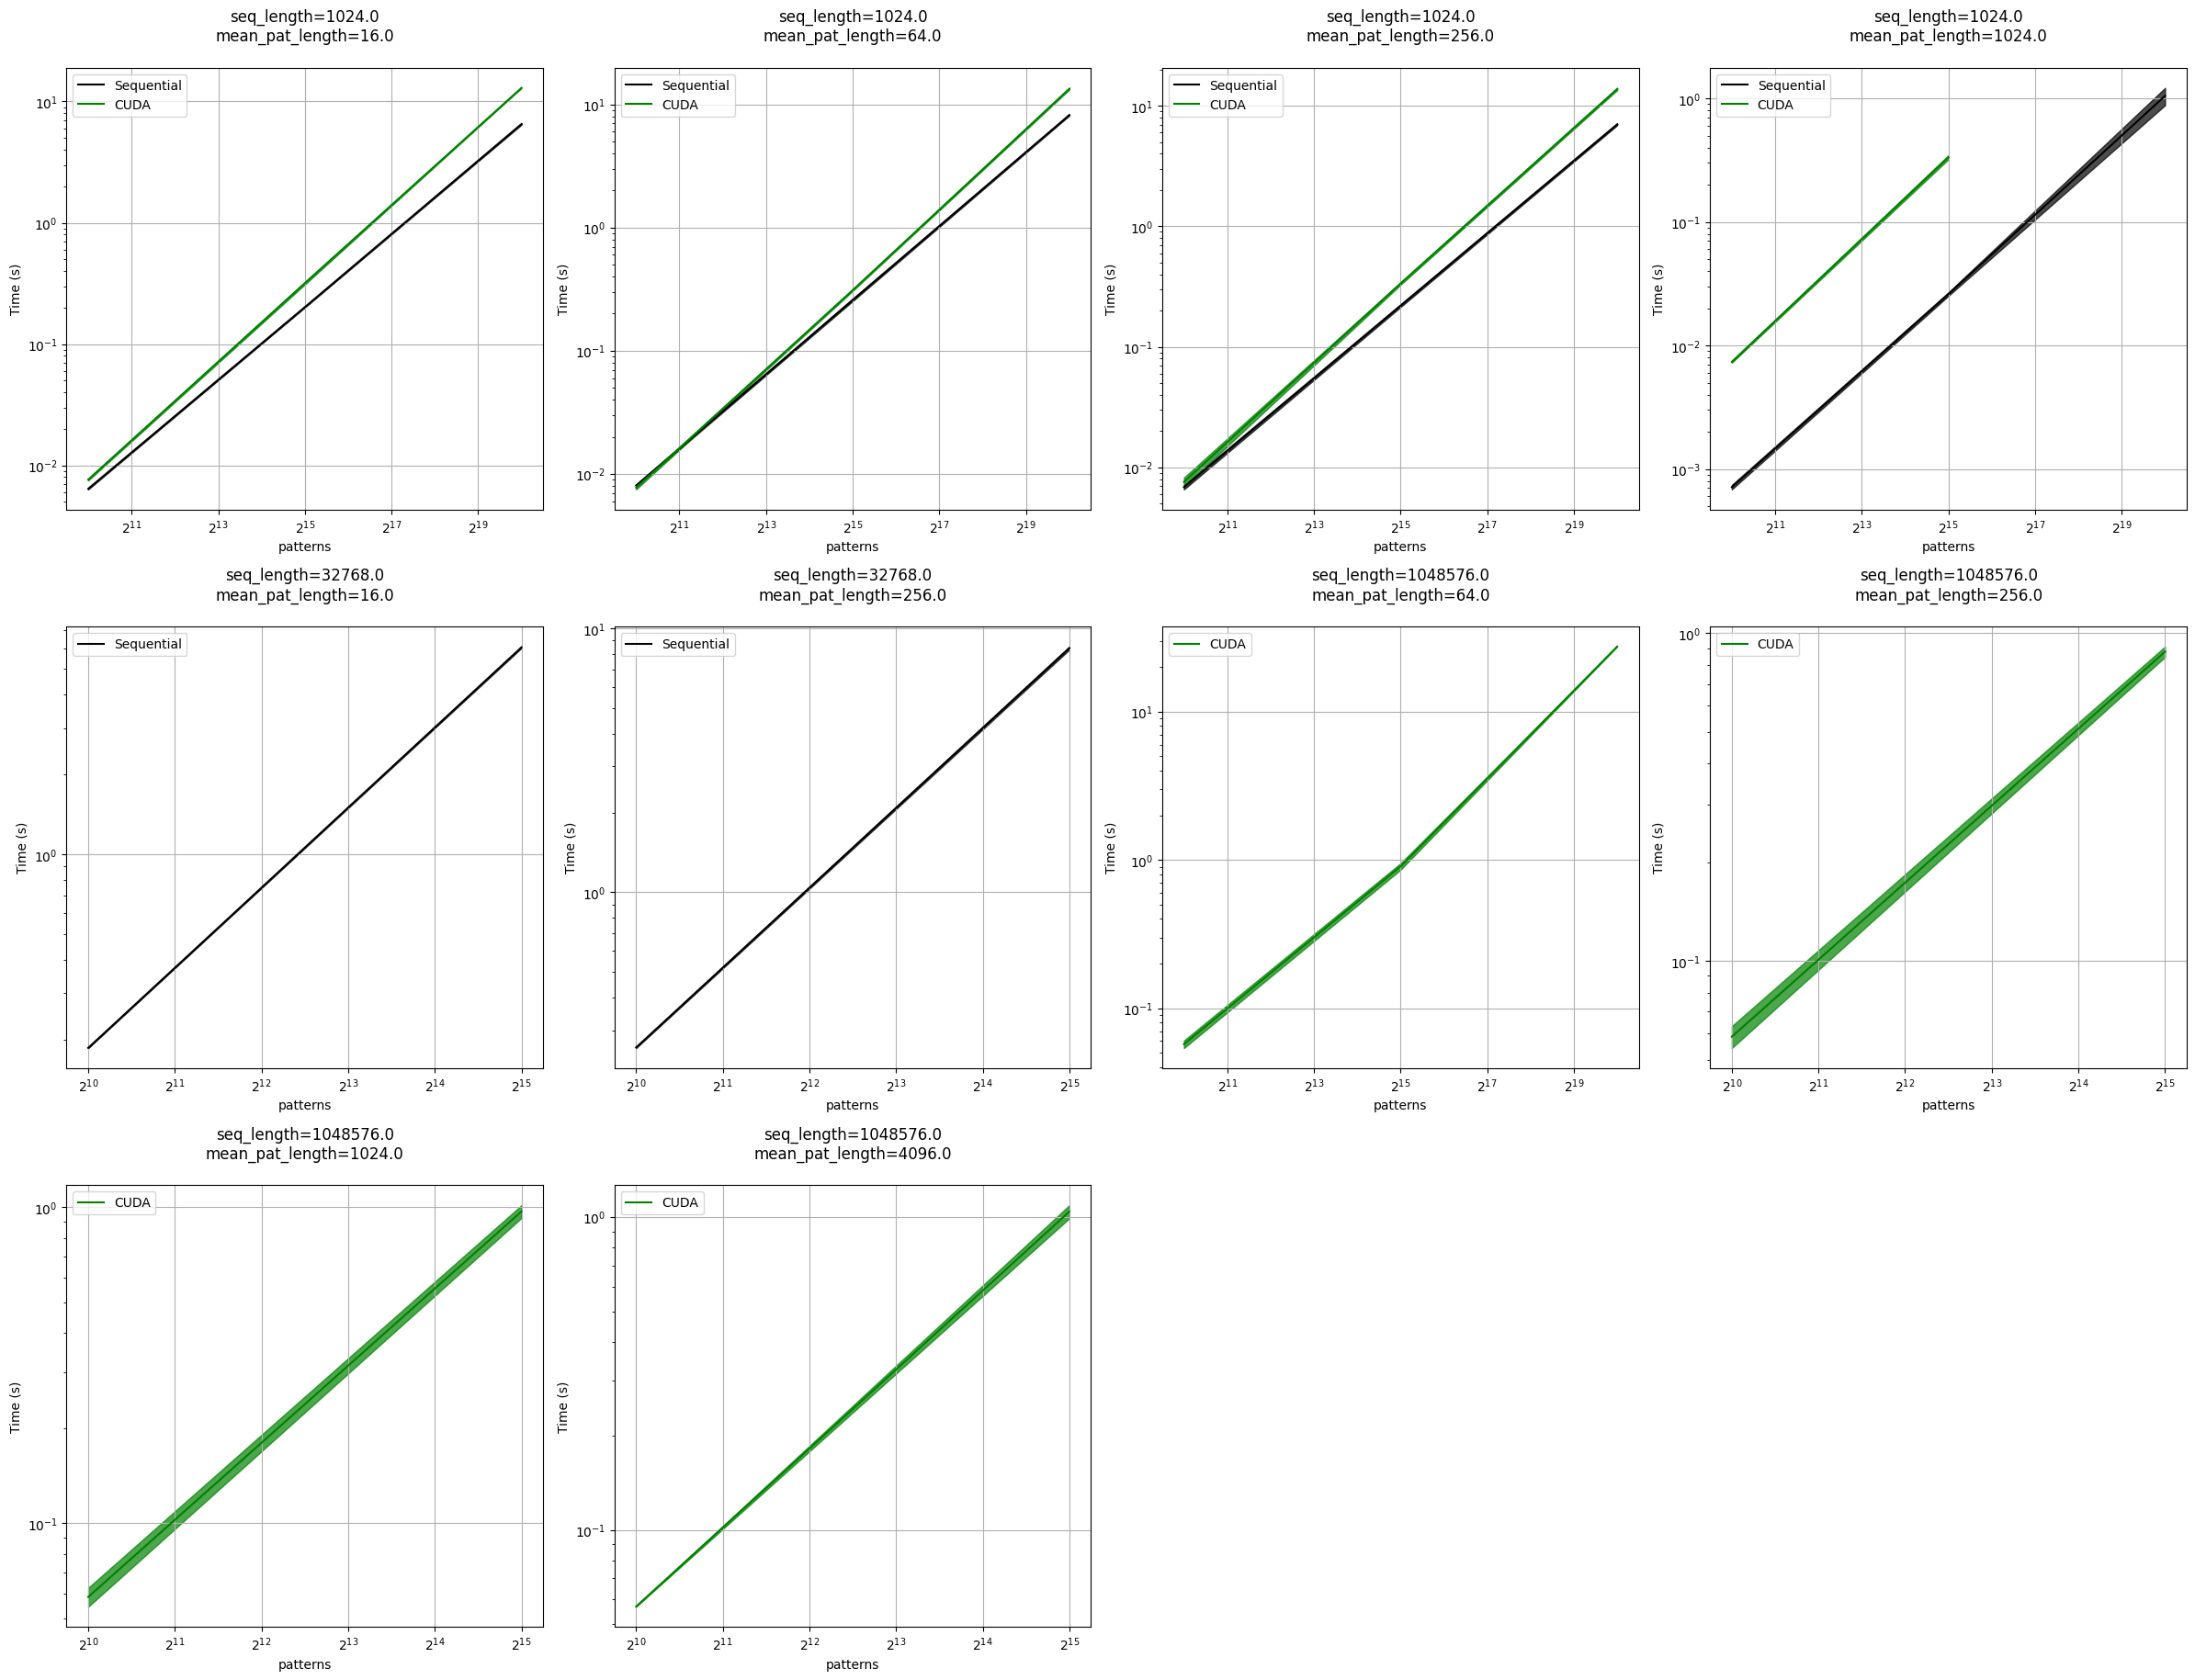

In [37]:
plot_variable_sequential_cuda("patterns")

## MPI

In [25]:
def plot_variable_sequential_mpi(variable):
    """
    This function creates plots of mpi and sequential corresponding to the arrays created in comparison.
    Check comparison's description for a thorough explanation.

    Input:
     - variable: the variable we are comparing on

    Output:
     - a multifaceted graph of time vs variable, where each facet is a fixed configuration
       of the other variables (again, check comparison's description)
    """
    # Grouping measurements by fixing all the other variables but the chosen one
    # Check sequntial_vs_mpi for more info
    data = sequential_vs_mpi(variable)

    # Setting up the plots
    side = ceil(len(data) ** 0.5)
    fig, axis = plt.subplots(side, side)

    # Fixing the interesting indexes
    seq_idx = idx[variable]
    mpi_idx = idx[variable] + 1

    # Axis index
    fig_idx = 0
    last_idx = side**2 - 1

    # Removing plots that are exceeding
    while (last_idx >= len(data)):
        axis[last_idx//side][last_idx%side].remove()
        last_idx -= 1

    # Flag signaling that the present configuration has been plotted
    # This is useful for counting the number of plots
    flag = False

    # Plotting each and every grouping
    for const, seq, mpi in data:
        # Ordering groupings by the interesting variable
        #seq = seq[np.argsort(seq[:,seq_idx])]
        #pth = pth[np.argsort(pth[:,pth_idx])]
          
        # Plotting the sequential datapoints for the chosen grouping
        if seq.shape[0] >= 2:
            axis[int(fig_idx/side)][fig_idx%side].plot(seq[:, seq_idx], seq[:, -1], color='black', label = "Sequential (dashed expected results)")
            
            # Plotting a 95% ci 
            span = 1.96 * seq[:, -2]
            lower_ci = seq[:, -1] - span
            upper_ci = seq[:, -1] + span
            axis[int(fig_idx/side)][fig_idx%side].fill_between(seq[:, seq_idx], lower_ci, upper_ci, alpha = 0.7, color = "black")
            
            # Plotting the expected parallel speedup for the chosen grouping
            for num_cores, colour in zip((sorted(set(mpi[:, 0]))), ("red", "blue", "orange", "green")):
                exp_label = "Expected speedup for " + str(int(num_cores)) + " processes"
                def speedup(time):
                    return time/num_cores
                exp_par_time = np.apply_along_axis(speedup, 0, seq[:, -1])

                axis[int(fig_idx/side)][fig_idx%side].plot(seq[:, seq_idx], exp_par_time, color=colour, ls = "--")
            
            # Notifying that this figure has at least a line
            flag = True

        # Plotting the mpi datapoints for the chosen grouping:
        # We need to group again on each process number
        # THIS PART MUST BE CHANGED IF THE NUMBER OF VARIABLES CHANGES
        for j, colour in zip(sorted(set(mpi[:, 0])), ("red", "blue", "orange", "green")):
            mpi_group = mpi[mpi[:, 0] == j]
            if mpi_group.shape[0] >= 2:
                mpi_label = str(int(mpi_group[0, 0])) + " processes"

                axis[int(fig_idx/side)][fig_idx%side].plot(mpi_group[:, mpi_idx], mpi_group[:, -1], color=colour, label = mpi_label)
            
                # Plotting a 95% ci 
                span = 1.96 * mpi_group[:, -2]
                lower_ci = mpi_group[:, -1] - span
                upper_ci = mpi_group[:, -1] + span

                axis[int(fig_idx/side)][fig_idx%side].fill_between(mpi_group[:, mpi_idx], lower_ci, upper_ci, alpha = 0.7, color = colour)
                
                # Notifying that this figure has at least a line
                flag = True

        # Finishing the plot or notifying the reason of its absence
        title = ""
        i = 0
        for k in idx.keys():
            if k != variable and k != "mean_time" and k != "time_std":
                title += k + "=" + str(const[i]) + "\n"
                i += 1
        
        if flag:
            axis[int(fig_idx/side)][fig_idx%side].set_title(title)
            axis[int(fig_idx/side)][fig_idx%side].set_xlabel(variable)
            axis[int(fig_idx/side)][fig_idx%side].set_ylabel('Time (s)')
            axis[int(fig_idx/side)][fig_idx%side].set_yscale('log')
            axis[int(fig_idx/side)][fig_idx%side].set_xscale('log', base = 2)
            axis[int(fig_idx/side)][fig_idx%side].legend()
            axis[int(fig_idx/side)][fig_idx%side].grid()
            flag = False
            fig_idx += 1
        else:
            print("This configuration has not been print:")
            print(title)
            print(f"Number of sequential datapoints: {seq.shape[0]}")
            print(f"Number of MPI datapoints: {mpi.shape[0]}")
            print("------------------------------------------------")
            
            # Removing unused axes
            axis[last_idx//side][last_idx%side].remove()
            last_idx -= 1
                    
    fig.set_figheight(side*6)
    fig.set_figwidth(side*6)
    plt.tight_layout()
    plt.show()

In [26]:
#plot_variable_sequential_mpi("mean_pat_length")

## MPI+PThreads

In [116]:
def plot_variable_sequential_mpi_pthreads(variable):
    """
    This function creates plots of mpi+pthreads and sequential corresponding to the arrays created in comparison.
    Check comparison's description for a thorough explanation.

    Input:
     - variable: the variable we are comparing on

    Output:
     - a multifaceted graph of time vs variable, where each facet is a fixed configuration
       of the other variables (again, check comparison's description)
    """
    # Grouping measurements by fixing all the other variables but the chosen one
    # Check sequntial_vs_mpi for more info
    data = comparison_seq_pthreads(sequential, mpi_pthreads, idx, variable)

    # Setting up the plots
    side = ceil(len(data) ** 0.5)
    fig, axis = plt.subplots(side, side)

    # Fixing the interesting indexes
    seq_idx = idx[variable]
    mpi_idx = idx[variable] + 2

    # Axis index
    fig_idx = 0
    last_idx = side**2 - 1

    # Colour dictionary
    colours = {(4, 2): "red", (4, 4): "orange", (4, 8): "green", (8, 2): "aqua", (8, 4): "blue", (8, 8): "indigo"}

    # Removing plots that are exceeding
    while (last_idx >= len(data)):
        axis[last_idx//side][last_idx%side].remove()
        last_idx -= 1

    # Flag signaling that the present configuration has been plotted
    # This is useful for counting the number of plots
    flag = False

    # Plotting each and every grouping
    for const, seq, mpi in data:
        # Ordering groupings by the interesting variable
        #seq = seq[np.argsort(seq[:,seq_idx])]
        #pth = pth[np.argsort(pth[:,pth_idx])]
          
        # Plotting the sequential datapoints for the chosen grouping
        if seq.shape[0] >= 2:
            axis[int(fig_idx/side)][fig_idx%side].plot(seq[:, seq_idx], seq[:, -1], color='black', label = "Sequential (dashed expected results)")
            
            # Plotting a 95% ci 
            span = 1.96 * seq[:, -2]
            lower_ci = seq[:, -1] - span
            upper_ci = seq[:, -1] + span
            axis[int(fig_idx/side)][fig_idx%side].fill_between(seq[:, seq_idx], lower_ci, upper_ci, alpha = 0.7, color = "black")
            
            # Notifying that this figure has at least a line
            flag = True

        # Plotting the mpi+pthreads datapoints for the chosen grouping:
        # We need to group again on each process+thread number
        # THIS PART MUST BE CHANGED IF THE NUMBER OF VARIABLES CHANGES
        for j in sorted(set(mpi[:, 0])):
            for k in sorted(set(mpi[:, 1])):
                mpi_group = mpi[(mpi[:, 0] == j) & (mpi[:, 1] == k)]
                if mpi_group.shape[0] >= 2:
                    mpi_label = str(int(mpi_group[0, 0])) + " processes\n" + str(int(mpi_group[0, 1])) + " threads"
                    
                    axis[int(fig_idx/side)][fig_idx%side].plot(mpi_group[:, mpi_idx], mpi_group[:, -1], color=colours[(j, k)], label = mpi_label)
                
                    # Plotting a 95% ci 
                    span = 1.96 * mpi_group[:, -2]
                    lower_ci = mpi_group[:, -1] - span
                    upper_ci = mpi_group[:, -1] + span

                    axis[int(fig_idx/side)][fig_idx%side].fill_between(mpi_group[:, mpi_idx], lower_ci, upper_ci, alpha = 0.7, color = colours[(j, k)])
                    
                    # Notifying that this figure has at least a line
                    flag = True

        # Finishing the plot or notifying the reason of its absence
        title = ""
        i = 0
        for k in idx.keys():
            if k != variable and k != "mean_time" and k != "time_std":
                title += k + "=" + str(const[i]) + "\n"
                i += 1
        
        if flag:
            axis[int(fig_idx/side)][fig_idx%side].set_title(title)
            axis[int(fig_idx/side)][fig_idx%side].set_xlabel(variable)
            axis[int(fig_idx/side)][fig_idx%side].set_ylabel('Time (s)')
            axis[int(fig_idx/side)][fig_idx%side].set_yscale('log')
            axis[int(fig_idx/side)][fig_idx%side].set_xscale('log', base = 2)
            axis[int(fig_idx/side)][fig_idx%side].legend()
            axis[int(fig_idx/side)][fig_idx%side].grid()
            flag = False
            fig_idx += 1
        else:
            print("This configuration has not been print:")
            print(title)
            print(f"Number of sequential datapoints: {seq.shape[0]}")
            print(f"Number of MPI+PThreads datapoints: {mpi.shape[0]}")
            print("------------------------------------------------")
            
            # Removing unused axes
            axis[last_idx//side][last_idx%side].remove()
            last_idx -= 1
                    
    fig.set_figheight(side*6)
    fig.set_figwidth(side*6)
    plt.tight_layout()
    plt.show()

For configuration [1024.], there was not enough data.
Sequential data: 1
Parallel data: 1
For configuration [4096.], there was not enough data.
Sequential data: 0
Parallel data: 1
For configuration [16.], there was not enough data.
Sequential data: 0
Parallel data: 1
For configuration [256.], there was not enough data.
Sequential data: 0
Parallel data: 1
This configuration has not been print:
patterns=32768.0
mean_pat_length=4096.0

Number of sequential datapoints: 1
Number of MPI+PThreads datapoints: 5
------------------------------------------------
This configuration has not been print:
patterns=1048576.0
mean_pat_length=16.0

Number of sequential datapoints: 1
Number of MPI+PThreads datapoints: 6
------------------------------------------------
This configuration has not been print:
patterns=1048576.0
mean_pat_length=64.0

Number of sequential datapoints: 1
Number of MPI+PThreads datapoints: 5
------------------------------------------------


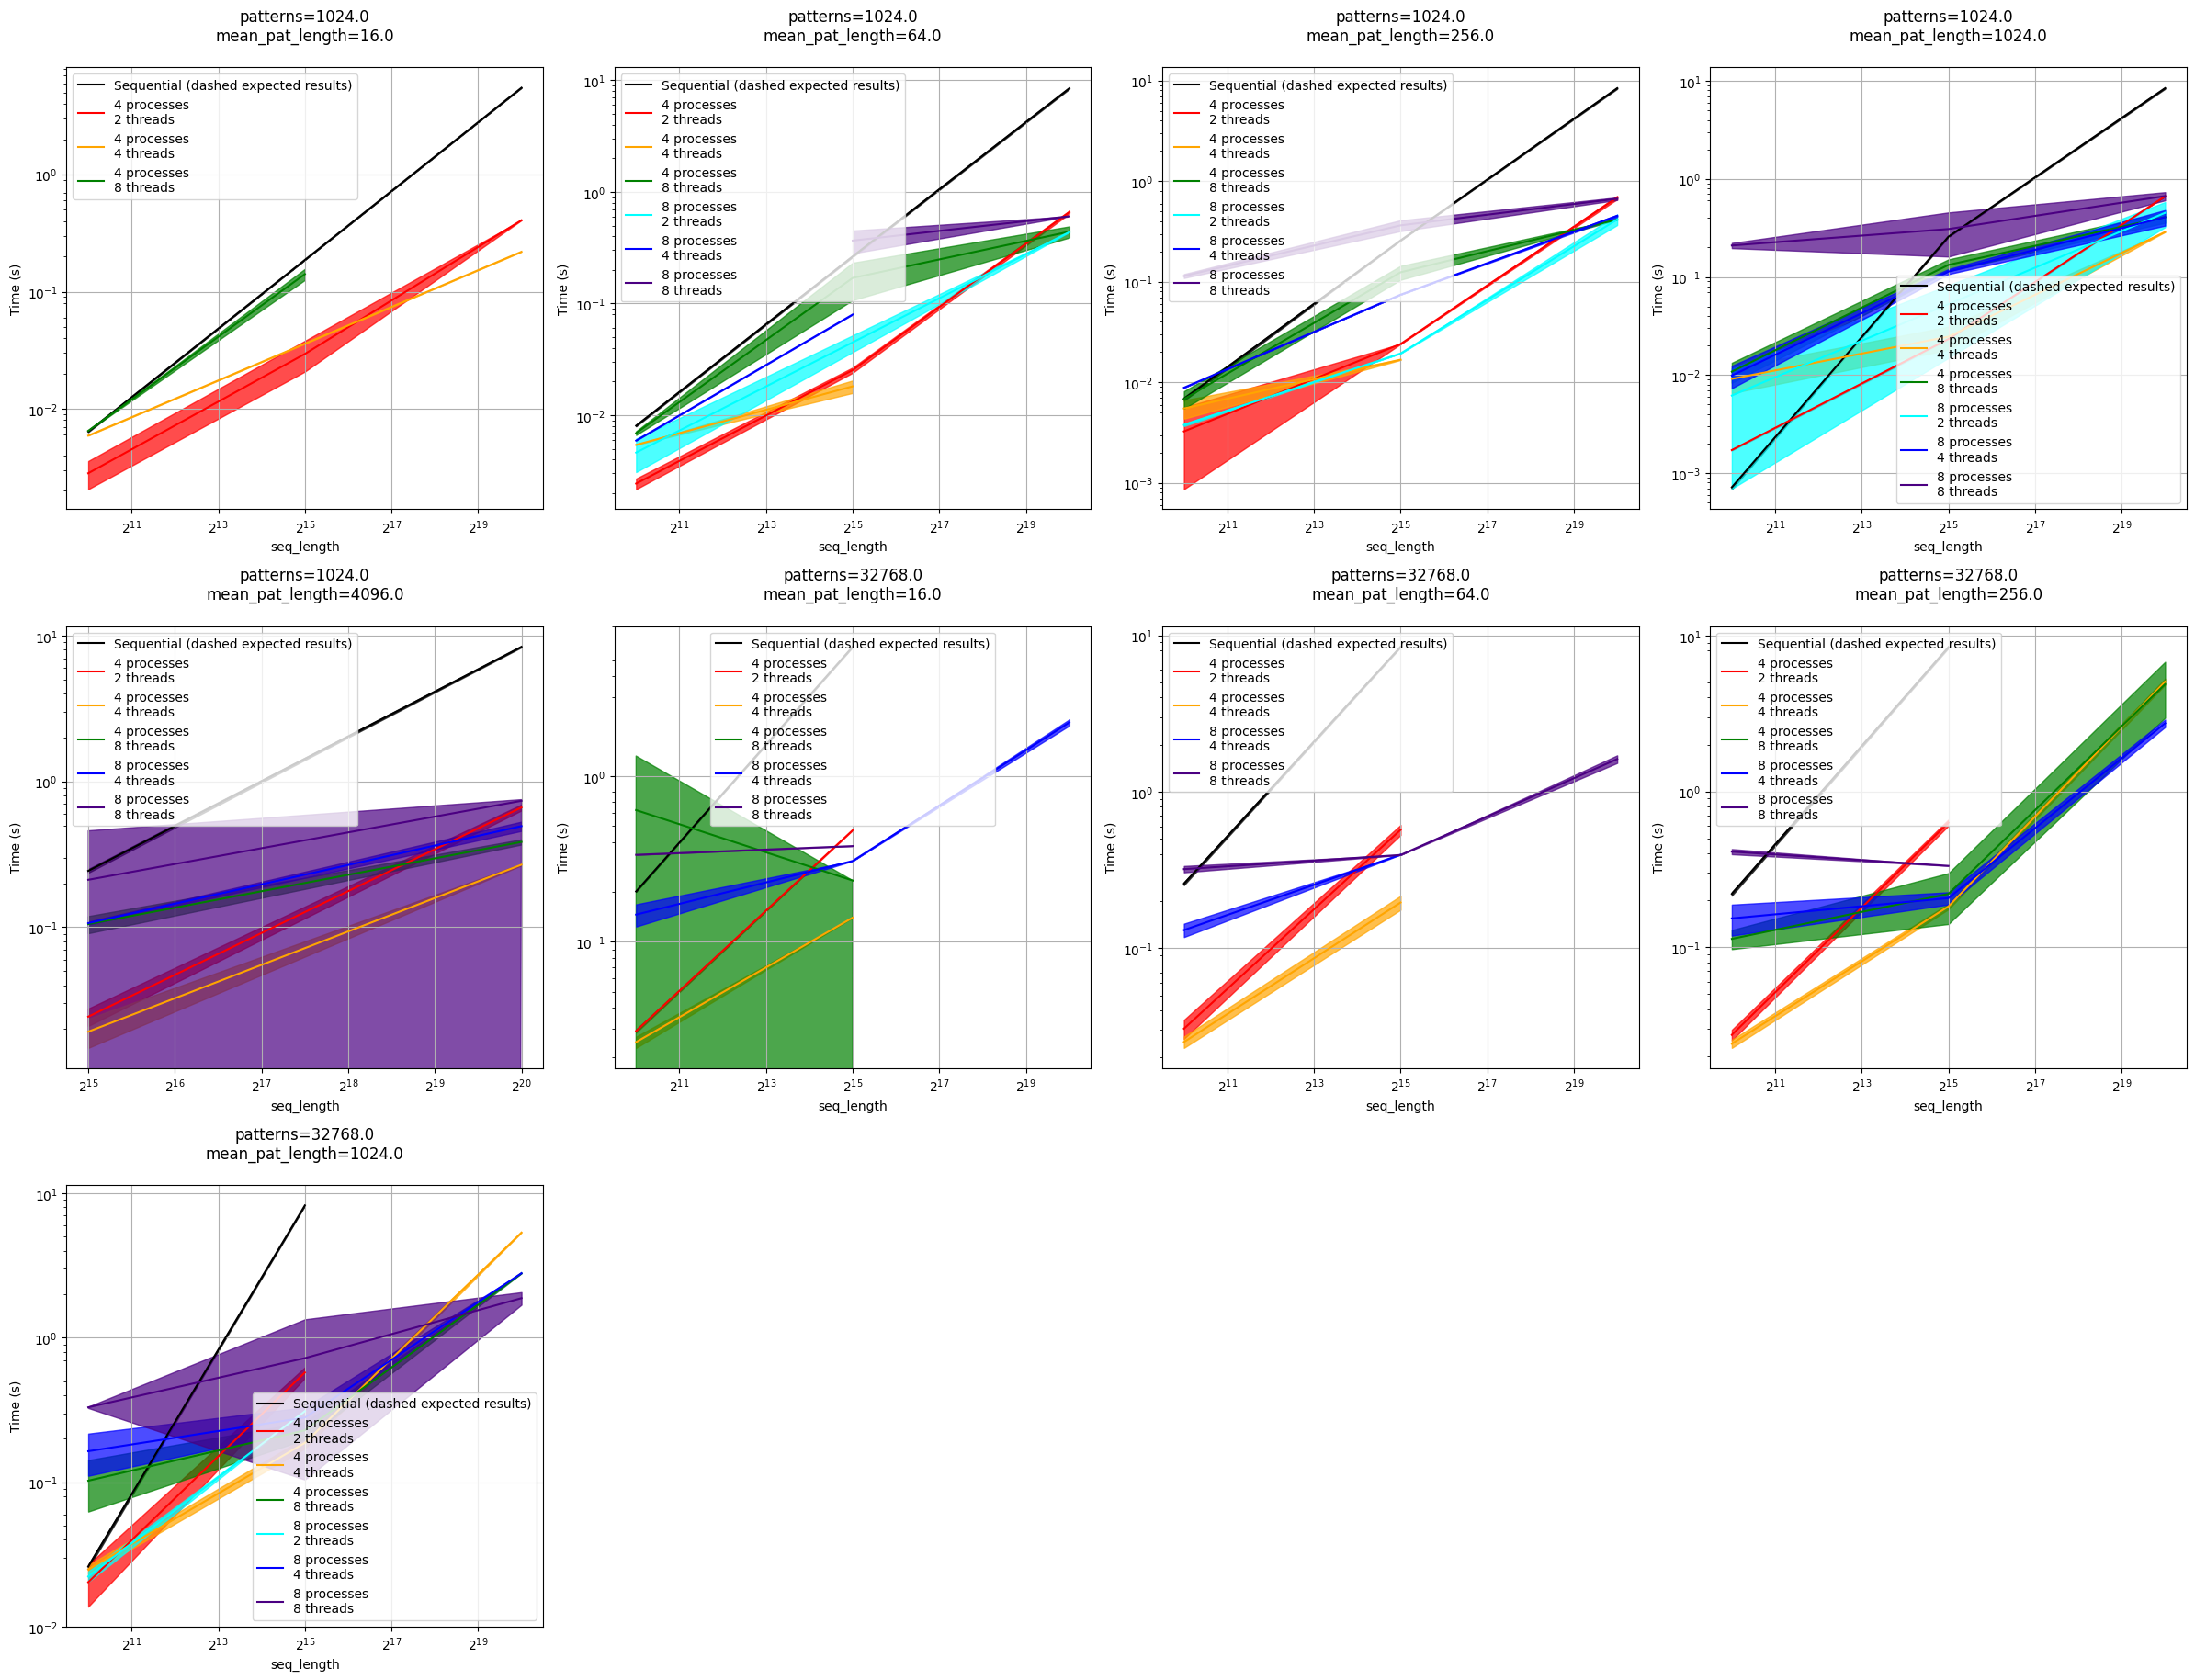

In [117]:
plot_variable_sequential_mpi_pthreads("seq_length")

# Times table

In [29]:
def times(variable, parallel):
    '''
    For each parallel test, it prints the times of the sequential counterpart and all the parallel ones.
    The times are confronted on a specific variable, while the other settings are kept constant.

    Input:
     - variable: the variable where the comparison takes place; either seq_length, patterns, or mean_path_length
     - parallel: the name of the parallel version we are testing, either pthreads or mpi

    Output: 
     - a series of printed panda dataframes, each for a specific configuration setting
    '''
    # Choosing the type of parallel data
    if parallel == "pthreads":
        data = sequential_vs_pthreads(variable)
        unit = "Threads"
    elif parallel == "mpi":
        data = sequential_vs_mpi(variable)
        unit = "Cores"

    # Extracting data for each configuration
    for config, seq, par in data:
        
        # Creating the title of the configuration
        title = f"Sequential vs {parallel} on {variable} for fixed\n"
        i = 0
        for k in idx.keys():
            if k != variable and k != "mean_time" and k != "time_std":
                title += k + "=" + str(config[i]) + "\n"
                i += 1
        print(title)

        # Creating the table
        units = np.append([1], sorted(set(par[:, 0]))).astype(dtype = np.int8)
        table = {unit: units}
        df = pd.DataFrame(table)

        measurements = sorted(set(par[:, idx[variable] + 1]))
        for i in measurements:
            df[i] = np.nan
        df = df.rename(index={i: x for i, x in enumerate(units)})
        df = df.drop(columns=unit)

        # Adding measurements
        for i in units:
            for j in df.columns:
                if i == 1:
                    # Checking that the specific test has ben run on this version
                    record = seq[seq[:, idx[variable]] == j]
                    if len(record) > 0:
                        df.loc[i, j] = record[:, -1].item()
                else:
                    # Checking that the specific test has ben run on this version
                    record = par[np.where((par[:, 0] == i) & (par[:, idx[variable] + 1] == j))]
                    if len(record) > 0:
                        df.loc[i, j] = record[:, -1].item()

        print(df)
        print("------------------------------------------------------------------------")

In [42]:
def times_mpipthreads(variable):
    '''
    For each parallel test, it prints the times of the sequential counterpart and all the parallel ones.
    The times are confronted on a specific variable, while the other settings are kept constant.

    Input:
     - variable: the variable where the comparison takes place; either seq_length, patterns, or mean_path_length
     - parallel: the name of the parallel version we are testing, either pthreads or mpi

    Output: 
     - a series of printed panda dataframes, each for a specific configuration setting
    '''
    # Saving data as panda dataframes
    seq_data = sequential
    par_data = mpi_pthreads
    seq = pd.DataFrame(seq_data)
    par = pd.DataFrame(par_data)

    # Renaming columns correctly
    seq.rename(columns={0: "seq_length", 1: "patterns", 2: "mean_pat_length", 3: "time_std", 4: "mean_time"}, inplace=True)
    par.rename(columns={0: "processes", 1: "threads", 2: "seq_length", 3: "patterns", 4: "mean_pat_length", 5: "time_std", 6: "mean_time"}, inplace=True)

    # Adding columns to sequential in such a way we can perform the join
    seq.insert(0, column="threads", value=1)
    seq.insert(0, column="processes", value=1)
    
    # Performing the merge
    result = seq.merge(par, how='inner', on=["seq_length", "patterns", "mean_pat_length"])
    result.sort_values(by = ['seq_length', 'patterns', 'mean_pat_length'], inplace=True)
    result["mean_time_y"] = result["mean_time_x"]/result["mean_time_y"]

    result.drop(columns=["processes_x", "threads_x", "time_std_x", "mean_time_x"], inplace=True)
    result.rename(columns={"processes_y": "processes", "threads_y": "threads", "time_std_y": "time_std", "mean_time_y": "speedup"}, inplace=True)
    result = result[["processes", "threads", "seq_length", "patterns", "mean_pat_length", "time_std", "speedup"]]
    if variable == "seq_length":
        result.sort_values(by = ['patterns', 'mean_pat_length', 'processes', 'threads', 'seq_length'], inplace=True)
    if variable == "patterns":
        result.sort_values(by = ['seq_length', 'mean_pat_length', 'processes', 'threads', 'patterns'], inplace=True)
    if variable == "mean_pat_length":
        result.sort_values(by = ['seq_length', 'patterns', 'processes', 'threads', 'mean_pat_length'], inplace=True)

    print(result.to_string())

In [45]:
times_mpipthreads("patterns")

     processes  threads  seq_length   patterns  mean_pat_length  time_std    speedup
0          4.0      2.0      1024.0     1024.0             16.0  0.000388   2.266797
20         4.0      2.0      1024.0    32768.0             16.0  0.000320   6.950098
44         4.0      2.0      1024.0  1048576.0             16.0  0.000000  10.956777
1          4.0      4.0      1024.0     1024.0             16.0  0.000000   1.082961
21         4.0      4.0      1024.0    32768.0             16.0  0.000991   8.109194
45         4.0      4.0      1024.0  1048576.0             16.0  0.000000  14.754909
2          4.0      8.0      1024.0     1024.0             16.0  0.000000   0.985268
22         4.0      8.0      1024.0    32768.0             16.0  0.357103   0.322862
46         4.0      8.0      1024.0  1048576.0             16.0  0.000000   7.462825
23         8.0      2.0      1024.0    32768.0             16.0  0.002329   7.095259
24         8.0      4.0      1024.0    32768.0             16.0  

In [40]:
def times_cuda(variable):
    '''
    For each parallel test, it prints the times of the sequential counterpart and all the parallel ones.
    The times are confronted on a specific variable, while the other settings are kept constant.

    Input:
     - variable: the variable where the comparison takes place; either seq_length, patterns, or mean_path_length
     - parallel: the name of the parallel version we are testing, either pthreads or mpi

    Output: 
     - a series of printed panda dataframes, each for a specific configuration setting
    '''
    # Saving data as panda dataframes
    seq_data = sequential
    par_data = cuda
    seq = pd.DataFrame(seq_data)
    par = pd.DataFrame(par_data)

    # Renaming columns correctly
    seq.rename(columns={0: "seq_length", 1: "patterns", 2: "mean_pat_length", 3: "time_std", 4: "mean_time"}, inplace=True)
    par.rename(columns={0: "seq_length", 1: "patterns", 2: "mean_pat_length", 3: "time_std", 4: "mean_time"}, inplace=True)
    
    # Performing the merge
    result = seq.merge(par, how='inner', on=["seq_length", "patterns", "mean_pat_length"])
    result.sort_values(by = ['seq_length', 'patterns', 'mean_pat_length'], inplace=True)
    result["mean_time_y"] = result["mean_time_x"]/result["mean_time_y"]

    result.drop(columns=["time_std_x", "mean_time_x"], inplace=True)
    result.rename(columns={"time_std_y": "time_std", "mean_time_y": "speedup"}, inplace=True)
    result = result[["seq_length", "patterns", "mean_pat_length", "time_std", "speedup"]]
    if variable == "seq_length":
        result.sort_values(by = ['patterns', 'mean_pat_length', 'seq_length'], inplace=True)
    if variable == "patterns":
        result.sort_values(by = ['seq_length', 'mean_pat_length', 'patterns'], inplace=True)
    if variable == "mean_pat_length":
        result.sort_values(by = ['seq_length', 'patterns', 'mean_pat_length'], inplace=True)

    print(result.to_string())

In [41]:
times_cuda("patterns")

    seq_length   patterns  mean_pat_length  time_std     speedup
0       1024.0     1024.0             16.0  0.000066    0.840232
4       1024.0    32768.0             16.0  0.003981    0.634652
8       1024.0  1048576.0             16.0  0.000861    0.503299
1       1024.0     1024.0             64.0  0.000121    1.042873
5       1024.0    32768.0             64.0  0.002272    0.832950
9       1024.0  1048576.0             64.0  0.112115    0.611882
2       1024.0     1024.0            256.0  0.000333    0.904403
6       1024.0    32768.0            256.0  0.004216    0.654721
10      1024.0  1048576.0            256.0  0.152228    0.509129
3       1024.0     1024.0           1024.0  0.000063    0.096864
7       1024.0    32768.0           1024.0  0.006505    0.078062
11     32768.0     1024.0             16.0  0.000033   15.856279
12   1048576.0     1024.0             16.0  0.002798   33.555087
13   1048576.0     1024.0             64.0  0.001718  148.690512
14   1048576.0     1024.0

# Efficiency table

In [78]:
def efficiency(variable, parallel):
    '''
    For each sequential test, it prints the efficiency of a relative parallel version.
    The efficiency rates are confronted on a specific variable, while the other settings are kept constant.

    Input:
     - variable: the variable where the comparison takes place; either seq_length, patterns, or mean_path_length
     - parallel: the name of the parallel version we are testing, either pthreads or mpi

    Output: 
     - a series of printed panda dataframes, each for a specific configuration setting
    '''
    # Choosing the type of parallel data
    if parallel == "pthreads":
        data = sequential_vs_pthreads(variable)
        unit = "Threads"
    elif parallel == "mpi":
        data = sequential_vs_mpi(variable)
        unit = "Processes"

    # Extracting data for each configuration
    for config, seq, par in data:
        
        # Creating the title of the configuration
        title = f"Sequential vs {parallel} on {variable} for fixed\n"
        i = 0
        for k in idx.keys():
            if k != variable and k != "mean_time" and k != "time_std":
                title += k + "=" + str(config[i]) + "\n"
                i += 1
        print(title)

        # Creating the table
        units = np.append([1], sorted(set(par[:, 0]))).astype(dtype = np.int8)
        table = {unit: units}
        df = pd.DataFrame(table)

        measurements = seq[:, idx[variable]]
        for i in measurements:
            df[i] = np.nan
        df = df.rename(index={i: x for i, x in enumerate(units)})
        df = df.drop(columns=unit)

        # Adding measurements
        for i in units:
            if i == 1:
                df.loc[i] = seq[:, -1]
            else:
                for j in df.columns:
                    record = par[np.where((par[:, 0] == i) & (par[:, idx[variable] + 1] == j))]
                    if len(record) > 0:
                        # Checking that the specific test has ben run on this version
                        df.loc[i, j] = record[:, -1].item()

        # Normalization
        for i in units[::-1]:
            df.loc[i] = df.loc[1] / (i * df.loc[i])

        print(df)
        print("------------------------------------------------------------------------")

In [79]:
#efficiency("mean_pat_length", "mpi")

Sequential vs mpi on mean_pat_length for fixed
seq_length=1024.0
patterns=1024.0

       16.0      64.0     256.0    1024.0
1  1.000000  1.000000  1.000000  1.000000
2  0.892351  0.925908  0.879937  0.408565
4  0.634296  0.697459  0.684906  0.081536
8  0.365932  0.413940  0.390188  0.056801
------------------------------------------------------------------------
Sequential vs mpi on mean_pat_length for fixed
seq_length=1024.0
patterns=32768.0

       16.0      64.0     256.0    1024.0
1  1.000000  1.000000  1.000000  1.000000
2  0.940319  1.000080  0.979190  0.449516
4  0.865226  0.941539  0.876677  0.269680
8  0.735824  0.811202  0.771549  0.173604
------------------------------------------------------------------------
Sequential vs mpi on mean_pat_length for fixed
seq_length=1024.0
patterns=1048576.0

       16.0      64.0     256.0    1024.0
1  1.000000  1.000000  1.000000  1.000000
2  0.966878  0.985443  0.969591  0.644924
4  0.927472  0.961663  0.939485  0.556853
8  0.813038  0.8

# Saving final results


## Support functions

In [101]:
def final_dataset(paradigm):
    match paradigm:
        case "sequential":
            dataset = create_dataset("results/logs/sequential", len(idx))
        case "pthreads":
            dataset =  create_dataset("results/logs/pthreads", len(idx) + 1, first_setting_column=1)
        case "mpi/simple":
            dataset = create_dataset("results/logs/mpi", len(idx) + 1, first_setting_column=1, outname = "job.out.0")
        case "mpi/improved":
            dataset = create_dataset("results/logs/mpi_exp", len(idx) + 1, first_setting_column=1, outname = "job.out.0")
        case "mpi/broadcast":
            dataset = create_dataset("results/logs/mpi_bcast", len(idx) + 1, first_setting_column=1, outname = "job.out.0")
        case "cuda":
            dataset = create_dataset("results/logs/cuda", len(idx))
        case "mpipthreads":
            dataset = create_dataset("results/logs/mpipthreads", len(idx) + 2, first_setting_column=2, outname = "job.out.0")
        case _:
            print("Error in paradigm input")
            return
    
    return dataset

In [72]:
def final_efficiency(variable, parallel):
    '''
    For each sequential test, it prints the efficiency of a relative parallel version.
    The efficiency rates are confronted on a specific variable, while the other settings are kept constant.

    Input:
     - variable: the variable where the comparison takes place; either seq_length, patterns, or mean_path_length
     - parallel: the name of the parallel version we are testing, either pthreads or mpi

    Output: 
     - a series of printed panda dataframes, each for a specific configuration setting
    '''
    # Choosing the type of parallel data
    if parallel == "pthreads":
        data = comparison_mod(final_dataset("sequential"), final_dataset("pthreads"), idx, variable)
        unit = "Threads"
    elif parallel == "mpi":
        data = comparison_mod(final_dataset("sequential"), final_dataset("mpi/simple"), idx, variable)
        unit = "Processes"
    elif parallel == "mpi_bcast":
        data = comparison_mod(final_dataset("sequential"), final_dataset("mpi/broadcast"), idx, variable)
        unit = "Processes"
    elif parallel == "mpi_exp":
        data = comparison_mod(final_dataset("sequential"), final_dataset("mpi/improved"), idx, variable)
        unit = "Processes"

    # Extracting data for each configuration
    for config, seq, par in data:
        
        # Creating the title of the configuration
        title = f"Sequential vs {parallel} on {variable} for fixed\n"
        i = 0
        for k in idx.keys():
            if k != variable and k != "mean_time" and k != "time_std":
                title += k + "=" + str(config[i]) + "\n"
                i += 1
        print(title)

        # Creating the table
        units = np.append([1], sorted(set(par[:, 0]))).astype(dtype = np.int8)
        table = {unit: units}
        df = pd.DataFrame(table)

        measurements = seq[:, idx[variable]]
        for i in measurements:
            df[i] = np.nan
        df = df.rename(index={i: x for i, x in enumerate(units)})
        df = df.drop(columns=unit)

        # Adding measurements
        for i in units:
            if i == 1:
                df.loc[i] = seq[:, -1]
            else:
                for j in df.columns:
                    record = par[np.where((par[:, 0] == i) & (par[:, idx[variable] + 1] == j))]
                    if len(record) > 0:
                        # Checking that the specific test has ben run on this version
                        df.loc[i, j] = record[:, -1].item()

        # Normalization
        for i in units[::-1]:
            df.loc[i] = df.loc[1] / (i * df.loc[i])

        print(df)
        print("------------------------------------------------------------------------")

## Times

In [103]:
def write_dataset(paradigm):
    dataset = final_dataset(paradigm)
    with open(f"final_folder/results/{paradigm}/times.txt", 'w') as f:
        f.write("\n".join(map(str, dataset)))

In [104]:
write_dataset("mpipthreads")

## Plots

In [84]:
def save_plot_variable_sequential_pthreads(variable):
    """
    This function creates plots of pthreads and sequential corresponding to the arrays created in comparison.
    Check comparison's description for a thorough explanation.

    Input:
     - variable: the variable we are comparing on

    Output:
     - a multifaceted graph of time vs variable, where each facet is a fixed configuration
       of the other variables (again, check comparison's description)
    """
    # Grouping measurements by fixing all the other variables but the chosen one
    # Check sequntial_vs_pthreads for more info
    data = comparison_mod(final_dataset("sequential"), final_dataset("pthreads"), idx, variable)  

    # Setting up the plots
    side = ceil(len(data) ** 0.5)
    fig, axis = plt.subplots(side, side)

    # Fixing the interesting indexes
    seq_idx = idx[variable]
    pth_idx = idx[variable] + 1

    # Axis index
    fig_idx = 0
    last_idx = side**2 - 1

    # Removing plots that are exceeding
    while (last_idx >= len(data)):
        axis[last_idx//side][last_idx%side].remove()
        last_idx -= 1

    # Flag signaling that the present configuration has been plotted
    # This is useful for counting the number of plots
    flag = False

    # Plotting each and every grouping
    for const, seq, pth in data:
        # Ordering groupings by the interesting variable
        #seq = seq[np.argsort(seq[:,seq_idx])]
        #pth = pth[np.argsort(pth[:,pth_idx])]
          
        # Plotting the sequential datapoints for the chosen grouping
        if seq.shape[0] >= 2:
            axis[int(fig_idx/side)][fig_idx%side].plot(seq[:, seq_idx], seq[:, -1], color='black', label = "Sequential (dashed expected results)")
            
            # Plotting a 95% ci 
            span = 1.96 * seq[:, -2]
            lower_ci = seq[:, -1] - span
            upper_ci = seq[:, -1] + span
            axis[int(fig_idx/side)][fig_idx%side].fill_between(seq[:, seq_idx], lower_ci, upper_ci, alpha = 0.7, color = "black")
            
            # Plotting the expected parallel speedup for the chosen grouping
            for num_cores, colour in zip((sorted(set(pth[:, 0]))), ("red", "blue", "orange", "green")):
                exp_label = "Expected speedup for " + str(int(num_cores)) + " threads"
                def speedup(time):
                    return time/num_cores
                exp_par_time = np.apply_along_axis(speedup, 0, seq[:, -1])

                axis[int(fig_idx/side)][fig_idx%side].plot(seq[:, seq_idx], exp_par_time, color=colour, ls = "--")
            
            # Notifying that this figure has at least a line
            flag = True

        # Plotting the pthreads datapoints for the chosen grouping:
        # We need to group again on each thread number
        # THIS PART MUST BE CHANGED IF THE NUMBER OF VARIABLES CHANGES
        for j, colour in zip(sorted(set(pth[:, 0])), ("red", "blue", "orange", "green")):
            pth_group = pth[pth[:, 0] == j]
            if pth_group.shape[0] >= 2:
                pth_label = str(int(pth_group[0, 0])) + " threads"

                axis[int(fig_idx/side)][fig_idx%side].plot(pth_group[:, pth_idx], pth_group[:, -1], color=colour, label = pth_label)
            
                # Plotting a 95% ci 
                span = 1.96 * pth_group[:, -2]
                lower_ci = pth_group[:, -1] - span
                upper_ci = pth_group[:, -1] + span

                axis[int(fig_idx/side)][fig_idx%side].fill_between(pth_group[:, pth_idx], lower_ci, upper_ci, alpha = 0.7, color = colour)
                
                # Notifying that this figure has at least a line
                flag = True

        # Finishing the plot or notifying the reason of its absence
        title = ""
        i = 0
        for k in idx.keys():
            if k != variable and k != "mean_time" and k != "time_std":
                title += k + "=" + str(const[i]) + "\n"
                i += 1
        
        if flag:
            axis[int(fig_idx/side)][fig_idx%side].set_title(title)
            axis[int(fig_idx/side)][fig_idx%side].set_xlabel(variable)
            axis[int(fig_idx/side)][fig_idx%side].set_ylabel('Time (s)')
            axis[int(fig_idx/side)][fig_idx%side].set_yscale('log')
            axis[int(fig_idx/side)][fig_idx%side].set_xscale('log', base = 2)
            axis[int(fig_idx/side)][fig_idx%side].legend()
            axis[int(fig_idx/side)][fig_idx%side].grid()
            flag = False
            fig_idx += 1
        else:
            print("This configuration has not been print:")
            print(title)
            print(f"Number of sequential datapoints: {seq.shape[0]}")
            print(f"Number of PThreads datapoints: {pth.shape[0]}")
            print("------------------------------------------------")
            
            # Removing unused axes
            axis[last_idx//side][last_idx%side].remove()
            last_idx -= 1
                    
    fig.set_figheight(side*6)
    fig.set_figwidth(side*6)
    plt.tight_layout()
    plt.savefig(f"final_folder/results/pthreads/{variable}.png")

For configuration [33554432.], there was not enough data.
Sequential data: 0
Parallel data: 1


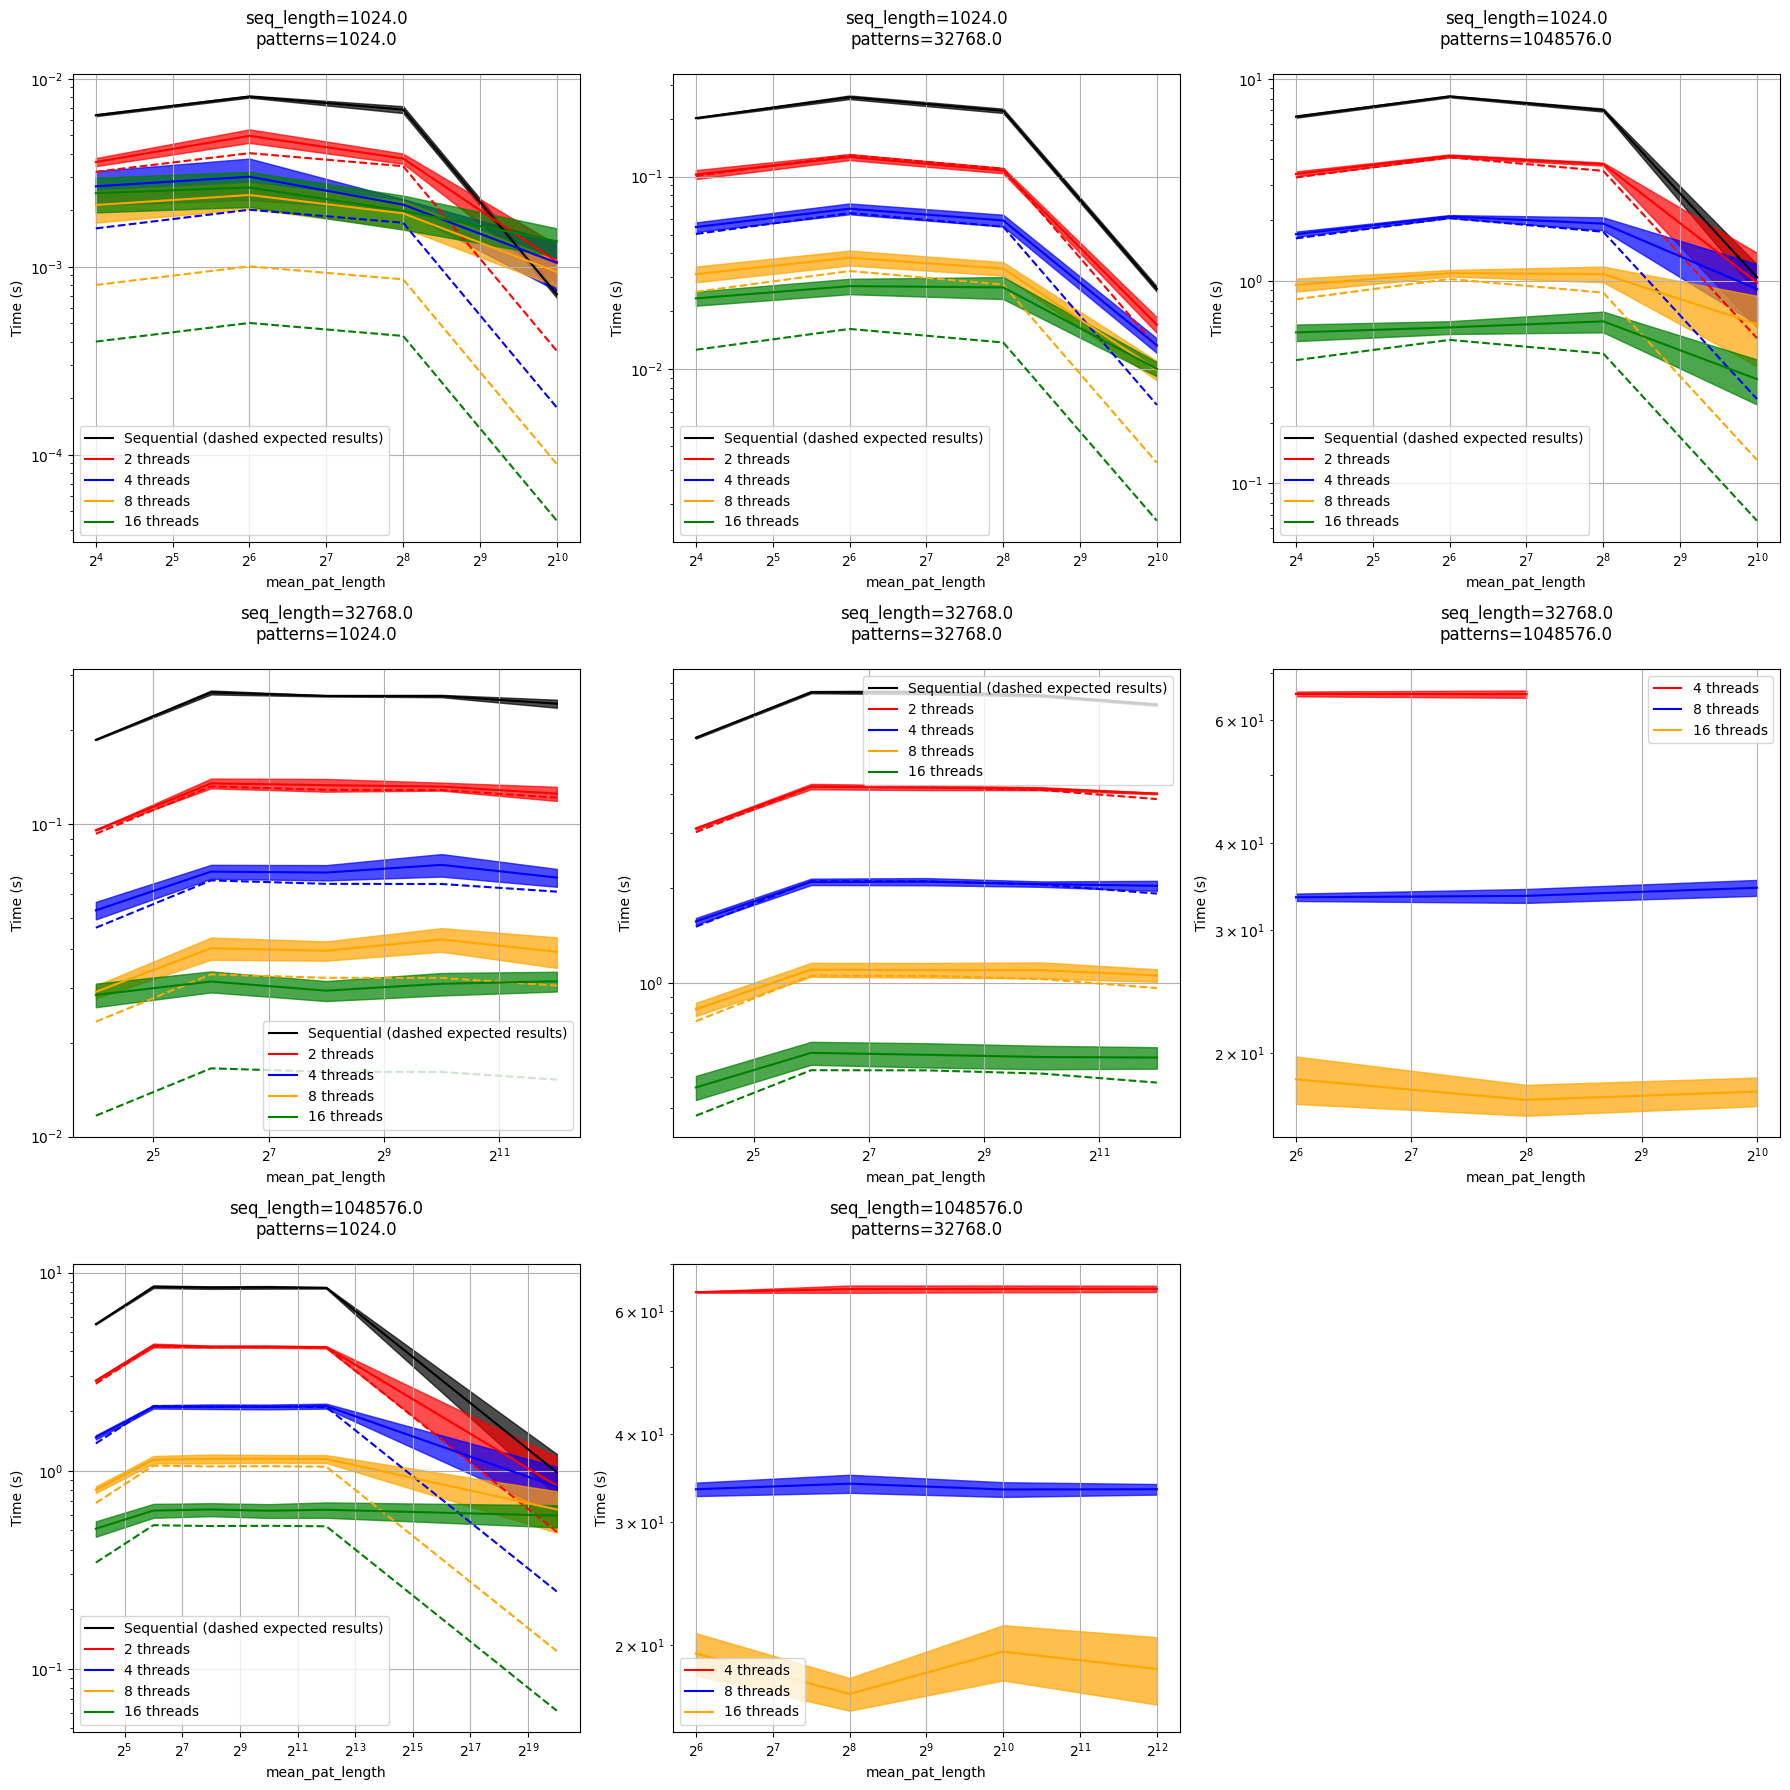

In [ ]:
#save_plot_variable_sequential_pthreads("mean_pat_length")

In [98]:
def save_plot_variable_sequential_cuda(variable):
    """
    This function creates plots of cuda and sequential corresponding to the arrays created in comparison.
    Check comparison's description for a thorough explanation.

    Input:
     - variable: the variable we are comparing on

    Output:
     - a multifaceted graph of time vs variable, where each facet is a fixed configuration
       of the other variables (again, check comparison's description)
    """
    # Grouping measurements by fixing all the other variables but the chosen one
    # Check sequntial_vs_cuda for more info
    data = data = comparison_cuda(final_dataset("sequential"), final_dataset("cuda"), idx, variable)  

    # Setting up the plots
    side = ceil(len(data) ** 0.5)
    fig, axis = plt.subplots(side, side)

    # Fixing the interesting indexes
    seq_idx = idx[variable]
    pth_idx = idx[variable]

    # Axis index
    fig_idx = 0
    last_idx = side**2 - 1

    # Removing plots that are exceeding
    while (last_idx >= len(data)):
        axis[last_idx//side][last_idx%side].remove()
        last_idx -= 1

    # Flag signaling that the present configuration has been plotted
    # This is useful for counting the number of plots
    flag = False

    # Plotting each and every grouping
    for const, seq, pth in data:
        # Ordering groupings by the interesting variable
        #seq = seq[np.argsort(seq[:,seq_idx])]
        #pth = pth[np.argsort(pth[:,pth_idx])]
          
        # Plotting the sequential datapoints for the chosen grouping
        if seq.shape[0] >= 2:
            axis[int(fig_idx/side)][fig_idx%side].plot(seq[:, seq_idx], seq[:, -1], color='black', label = "Sequential")
            
            # Plotting a 95% ci 
            span = 1.96 * seq[:, -2]
            lower_ci = seq[:, -1] - span
            upper_ci = seq[:, -1] + span
            axis[int(fig_idx/side)][fig_idx%side].fill_between(seq[:, seq_idx], lower_ci, upper_ci, alpha = 0.7, color = "black")
            
            # Notifying that this figure has at least a line
            flag = True

        # Plotting the pthreads datapoints for the chosen grouping:
        # We need to group again on each thread number
        # THIS PART MUST BE CHANGED IF THE NUMBER OF VARIABLES CHANGES
        if pth.shape[0] >= 2:
            pth_label = "CUDA"

            axis[int(fig_idx/side)][fig_idx%side].plot(pth[:, pth_idx], pth[:, -1], color="green", label = pth_label)
        
            # Plotting a 95% ci 
            span = 1.96 * pth[:, -2]
            lower_ci = pth[:, -1] - span
            upper_ci = pth[:, -1] + span

            axis[int(fig_idx/side)][fig_idx%side].fill_between(pth[:, pth_idx], lower_ci, upper_ci, alpha = 0.7, color = "green")
            
            # Notifying that this figure has at least a line
            flag = True

        # Finishing the plot or notifying the reason of its absence
        title = ""
        i = 0
        for k in idx.keys():
            if k != variable and k != "mean_time" and k != "time_std":
                title += k + "=" + str(const[i]) + "\n"
                i += 1
        
        if flag:
            axis[int(fig_idx/side)][fig_idx%side].set_title(title)
            axis[int(fig_idx/side)][fig_idx%side].set_xlabel(variable)
            axis[int(fig_idx/side)][fig_idx%side].set_ylabel('Time (s)')
            axis[int(fig_idx/side)][fig_idx%side].set_yscale('log')
            axis[int(fig_idx/side)][fig_idx%side].set_xscale('log', base = 2)
            axis[int(fig_idx/side)][fig_idx%side].legend()
            axis[int(fig_idx/side)][fig_idx%side].grid()
            flag = False
            fig_idx += 1
        else:
            print("This configuration has not been print:")
            print(title)
            print(f"Number of sequential datapoints: {seq.shape[0]}")
            print(f"Number of CUDA datapoints: {pth.shape[0]}")
            print("------------------------------------------------")
            
            # Removing unused axes
            axis[last_idx//side][last_idx%side].remove()
            last_idx -= 1
                    
    fig.set_figheight(side*6)
    fig.set_figwidth(side*6)
    plt.tight_layout()
    plt.savefig(f"final_folder/results/cuda/{variable}.png")

For configuration [  32768. 1048576.], there was not enough data.
Sequential data: 0
Parallel data: 1
For configuration [1048576. 1048576.], there was not enough data.
Sequential data: 0
Parallel data: 1


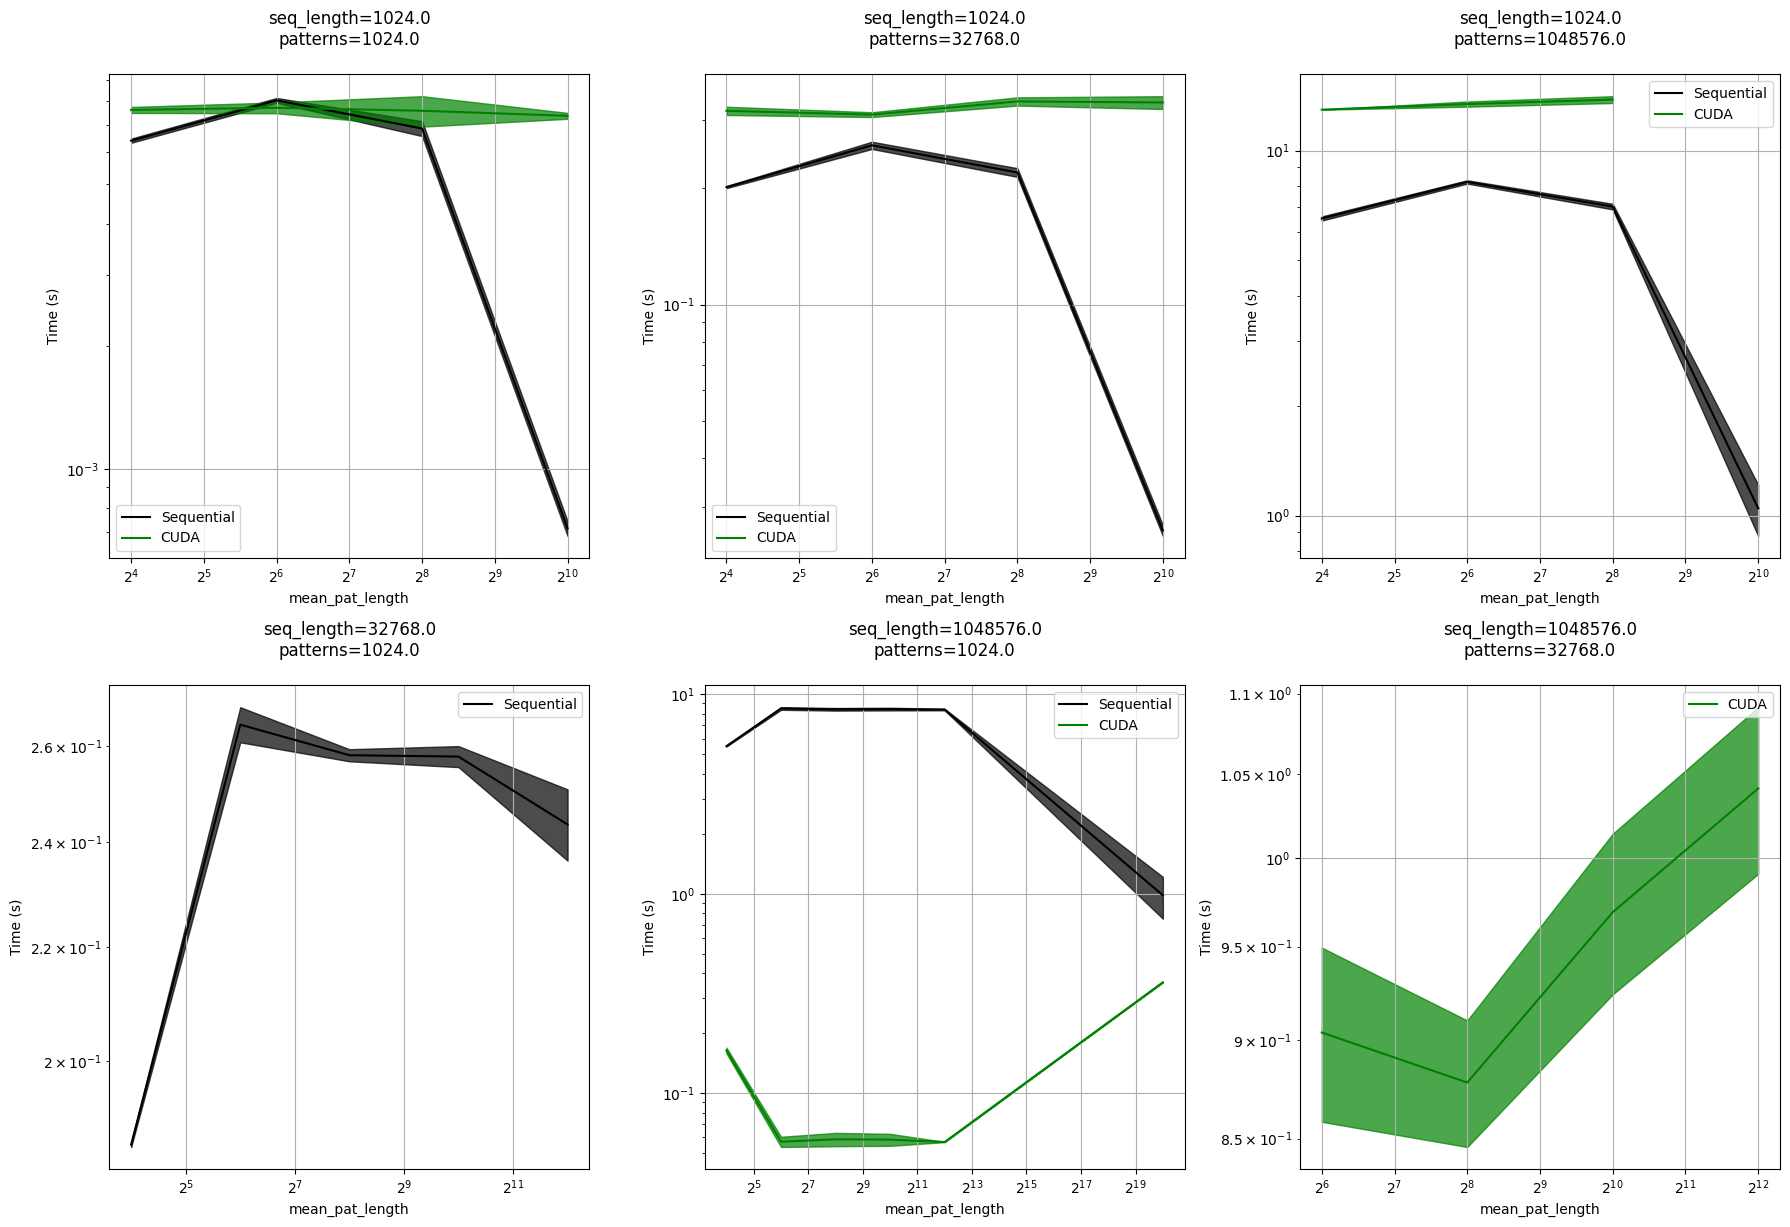

In [101]:
#save_plot_variable_sequential_cuda("mean_pat_length")

In [86]:
def save_plot_variable_sequential_mpi(path, variable):
    """
    This function creates plots of mpi and sequential corresponding to the arrays created in comparison.
    Check comparison's description for a thorough explanation.

    Input:
     - variable: the variable we are comparing on

    Output:
     - a multifaceted graph of time vs variable, where each facet is a fixed configuration
       of the other variables (again, check comparison's description)
    """
    # Grouping measurements by fixing all the other variables but the chosen one
    # Check sequntial_vs_mpi for more info
    data = comparison_mod(final_dataset("sequential"), final_dataset(path), idx, variable)  

    # Setting up the plots
    side = ceil(len(data) ** 0.5)
    fig, axis = plt.subplots(side, side)

    # Fixing the interesting indexes
    seq_idx = idx[variable]
    mpi_idx = idx[variable] + 1

    # Axis index
    fig_idx = 0
    last_idx = side**2 - 1

    # Removing plots that are exceeding
    while (last_idx >= len(data)):
        axis[last_idx//side][last_idx%side].remove()
        last_idx -= 1

    # Flag signaling that the present configuration has been plotted
    # This is useful for counting the number of plots
    flag = False

    # Plotting each and every grouping
    for const, seq, mpi in data:
        # Ordering groupings by the interesting variable
        #seq = seq[np.argsort(seq[:,seq_idx])]
        #pth = pth[np.argsort(pth[:,pth_idx])]
          
        # Plotting the sequential datapoints for the chosen grouping
        if seq.shape[0] >= 2:
            axis[int(fig_idx/side)][fig_idx%side].plot(seq[:, seq_idx], seq[:, -1], color='black', label = "Sequential (dashed expected results)")
            
            # Plotting a 95% ci 
            span = 1.96 * seq[:, -2]
            lower_ci = seq[:, -1] - span
            upper_ci = seq[:, -1] + span
            axis[int(fig_idx/side)][fig_idx%side].fill_between(seq[:, seq_idx], lower_ci, upper_ci, alpha = 0.7, color = "black")
            
            # Plotting the expected parallel speedup for the chosen grouping
            for num_cores, colour in zip((sorted(set(mpi[:, 0]))), ("red", "blue", "orange", "green")):
                exp_label = "Expected speedup for " + str(int(num_cores)) + " processes"
                def speedup(time):
                    return time/num_cores
                exp_par_time = np.apply_along_axis(speedup, 0, seq[:, -1])

                axis[int(fig_idx/side)][fig_idx%side].plot(seq[:, seq_idx], exp_par_time, color=colour, ls = "--")
            
            # Notifying that this figure has at least a line
            flag = True

        # Plotting the mpi datapoints for the chosen grouping:
        # We need to group again on each process number
        # THIS PART MUST BE CHANGED IF THE NUMBER OF VARIABLES CHANGES
        for j, colour in zip(sorted(set(mpi[:, 0])), ("red", "blue", "orange", "green")):
            mpi_group = mpi[mpi[:, 0] == j]
            if mpi_group.shape[0] >= 2:
                mpi_label = str(int(mpi_group[0, 0])) + " processes"

                axis[int(fig_idx/side)][fig_idx%side].plot(mpi_group[:, mpi_idx], mpi_group[:, -1], color=colour, label = mpi_label)
            
                # Plotting a 95% ci 
                span = 1.96 * mpi_group[:, -2]
                lower_ci = mpi_group[:, -1] - span
                upper_ci = mpi_group[:, -1] + span

                axis[int(fig_idx/side)][fig_idx%side].fill_between(mpi_group[:, mpi_idx], lower_ci, upper_ci, alpha = 0.7, color = colour)
                
                # Notifying that this figure has at least a line
                flag = True

        # Finishing the plot or notifying the reason of its absence
        title = ""
        i = 0
        for k in idx.keys():
            if k != variable and k != "mean_time" and k != "time_std":
                title += k + "=" + str(const[i]) + "\n"
                i += 1
        
        if flag:
            axis[int(fig_idx/side)][fig_idx%side].set_title(title)
            axis[int(fig_idx/side)][fig_idx%side].set_xlabel(variable)
            axis[int(fig_idx/side)][fig_idx%side].set_ylabel('Time (s)')
            axis[int(fig_idx/side)][fig_idx%side].set_yscale('log')
            axis[int(fig_idx/side)][fig_idx%side].set_xscale('log', base = 2)
            axis[int(fig_idx/side)][fig_idx%side].legend()
            axis[int(fig_idx/side)][fig_idx%side].grid()
            flag = False
            fig_idx += 1
        else:
            print("This configuration has not been print:")
            print(title)
            print(f"Number of sequential datapoints: {seq.shape[0]}")
            print(f"Number of MPI datapoints: {mpi.shape[0]}")
            print("------------------------------------------------")
            
            # Removing unused axes
            axis[last_idx//side][last_idx%side].remove()
            last_idx -= 1
                    
    fig.set_figheight(side*6)
    fig.set_figwidth(side*6)
    plt.tight_layout()
    plt.savefig(f"final_folder/results/{path}/{variable}.png")

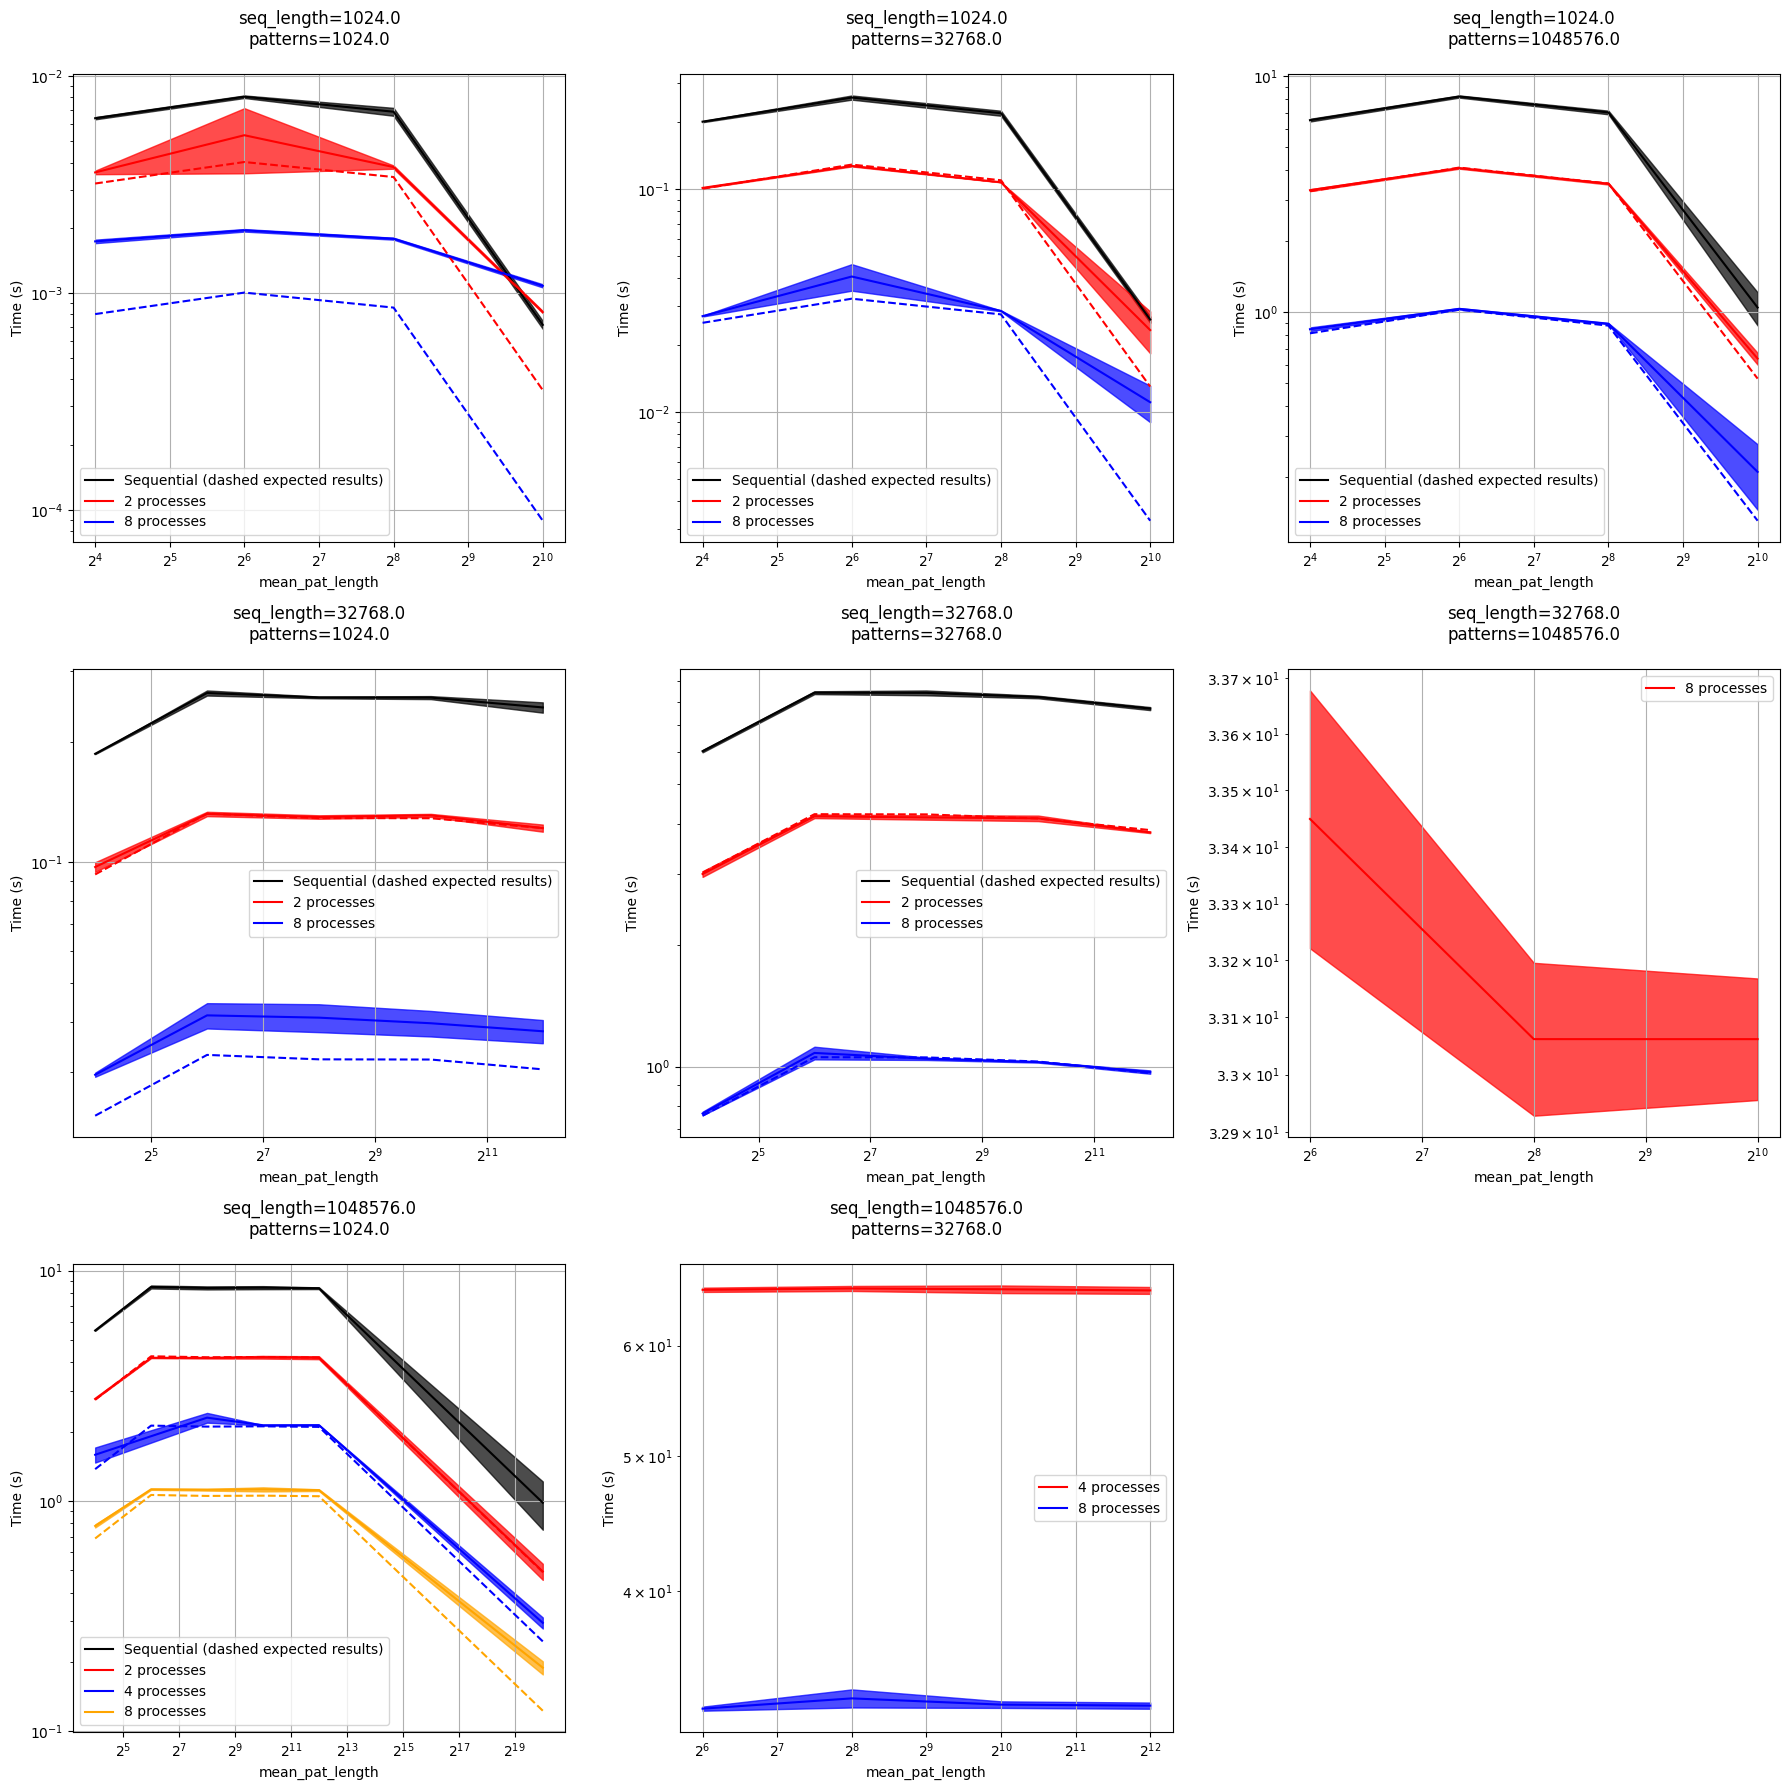

In [87]:
#save_plot_variable_sequential_mpi("mpi/broadcast", "mean_pat_length")

In [122]:
def save_plot_variable_sequential_mpipthreads(variable):
    """
    This function creates plots of mpi+pthreads and sequential corresponding to the arrays created in comparison.
    Check comparison's description for a thorough explanation.

    Input:
     - variable: the variable we are comparing on

    Output:
     - a multifaceted graph of time vs variable, where each facet is a fixed configuration
       of the other variables (again, check comparison's description)
    """
    # Grouping measurements by fixing all the other variables but the chosen one
    # Check sequntial_vs_mpi for more info
    data = comparison_seq_pthreads(final_dataset("sequential"), final_dataset("mpipthreads"), idx, variable)  

    # Setting up the plots
    side = ceil(len(data) ** 0.5)
    fig, axis = plt.subplots(side, side)

    # Fixing the interesting indexes
    seq_idx = idx[variable]
    mpi_idx = idx[variable] + 2

    # Axis index
    fig_idx = 0
    last_idx = side**2 - 1

    # Colour dictionary
    colours = {(4, 2): "red", (4, 4): "orange", (4, 8): "green", (8, 2): "aqua", (8, 4): "blue", (8, 8): "indigo"}

    # Removing plots that are exceeding
    while (last_idx >= len(data)):
        axis[last_idx//side][last_idx%side].remove()
        last_idx -= 1

    # Flag signaling that the present configuration has been plotted
    # This is useful for counting the number of plots
    flag = False

    # Plotting each and every grouping
    for const, seq, mpi in data:
        # Ordering groupings by the interesting variable
        #seq = seq[np.argsort(seq[:,seq_idx])]
        #pth = pth[np.argsort(pth[:,pth_idx])]
          
        # Plotting the sequential datapoints for the chosen grouping
        if seq.shape[0] >= 2:
            axis[int(fig_idx/side)][fig_idx%side].plot(seq[:, seq_idx], seq[:, -1], color='black', label = "Sequential")
            
            # Plotting a 95% ci 
            span = 1.96 * seq[:, -2]
            lower_ci = seq[:, -1] - span
            upper_ci = seq[:, -1] + span
            axis[int(fig_idx/side)][fig_idx%side].fill_between(seq[:, seq_idx], lower_ci, upper_ci, alpha = 0.7, color = "black")
            
            # Notifying that this figure has at least a line
            flag = True

        # Plotting the mpi+pthreads datapoints for the chosen grouping:
        # We need to group again on each process+thread number
        # THIS PART MUST BE CHANGED IF THE NUMBER OF VARIABLES CHANGES
        for j in sorted(set(mpi[:, 0])):
            for k in sorted(set(mpi[:, 1])):
                mpi_group = mpi[(mpi[:, 0] == j) & (mpi[:, 1] == k)]
                if mpi_group.shape[0] >= 2:
                    mpi_label = str(int(mpi_group[0, 0])) + " processes\n" + str(int(mpi_group[0, 1])) + " threads"
                    
                    axis[int(fig_idx/side)][fig_idx%side].plot(mpi_group[:, mpi_idx], mpi_group[:, -1], color=colours[(j, k)], label = mpi_label)
                
                    # Plotting a 95% ci 
                    span = 1.96 * mpi_group[:, -2]
                    lower_ci = mpi_group[:, -1] - span
                    upper_ci = mpi_group[:, -1] + span

                    axis[int(fig_idx/side)][fig_idx%side].fill_between(mpi_group[:, mpi_idx], lower_ci, upper_ci, alpha = 0.7, color = colours[(j, k)])
                    
                    # Notifying that this figure has at least a line
                    flag = True

        # Finishing the plot or notifying the reason of its absence
        title = ""
        i = 0
        for k in idx.keys():
            if k != variable and k != "mean_time" and k != "time_std":
                title += k + "=" + str(const[i]) + "\n"
                i += 1
        
        if flag:
            axis[int(fig_idx/side)][fig_idx%side].set_title(title)
            axis[int(fig_idx/side)][fig_idx%side].set_xlabel(variable)
            axis[int(fig_idx/side)][fig_idx%side].set_ylabel('Time (s)')
            axis[int(fig_idx/side)][fig_idx%side].set_yscale('log')
            axis[int(fig_idx/side)][fig_idx%side].set_xscale('log', base = 2)
            axis[int(fig_idx/side)][fig_idx%side].legend()
            axis[int(fig_idx/side)][fig_idx%side].grid()
            flag = False
            fig_idx += 1
        else:
            print("This configuration has not been print:")
            print(title)
            print(f"Number of sequential datapoints: {seq.shape[0]}")
            print(f"Number of MPI+PThreads datapoints: {mpi.shape[0]}")
            print("------------------------------------------------")
            
            # Removing unused axes
            axis[last_idx//side][last_idx%side].remove()
            last_idx -= 1
                    
    fig.set_figheight(side*6)
    fig.set_figwidth(side*6)
    plt.tight_layout()
    plt.savefig(f"final_folder/results/mpipthreads/{variable}.png")

For configuration [1024.], there was not enough data.
Sequential data: 1
Parallel data: 1
For configuration [4096.], there was not enough data.
Sequential data: 0
Parallel data: 1
For configuration [16.], there was not enough data.
Sequential data: 0
Parallel data: 1
For configuration [256.], there was not enough data.
Sequential data: 0
Parallel data: 1
This configuration has not been print:
patterns=32768.0
mean_pat_length=4096.0

Number of sequential datapoints: 1
Number of MPI+PThreads datapoints: 5
------------------------------------------------
This configuration has not been print:
patterns=1048576.0
mean_pat_length=16.0

Number of sequential datapoints: 1
Number of MPI+PThreads datapoints: 6
------------------------------------------------
This configuration has not been print:
patterns=1048576.0
mean_pat_length=64.0

Number of sequential datapoints: 1
Number of MPI+PThreads datapoints: 5
------------------------------------------------


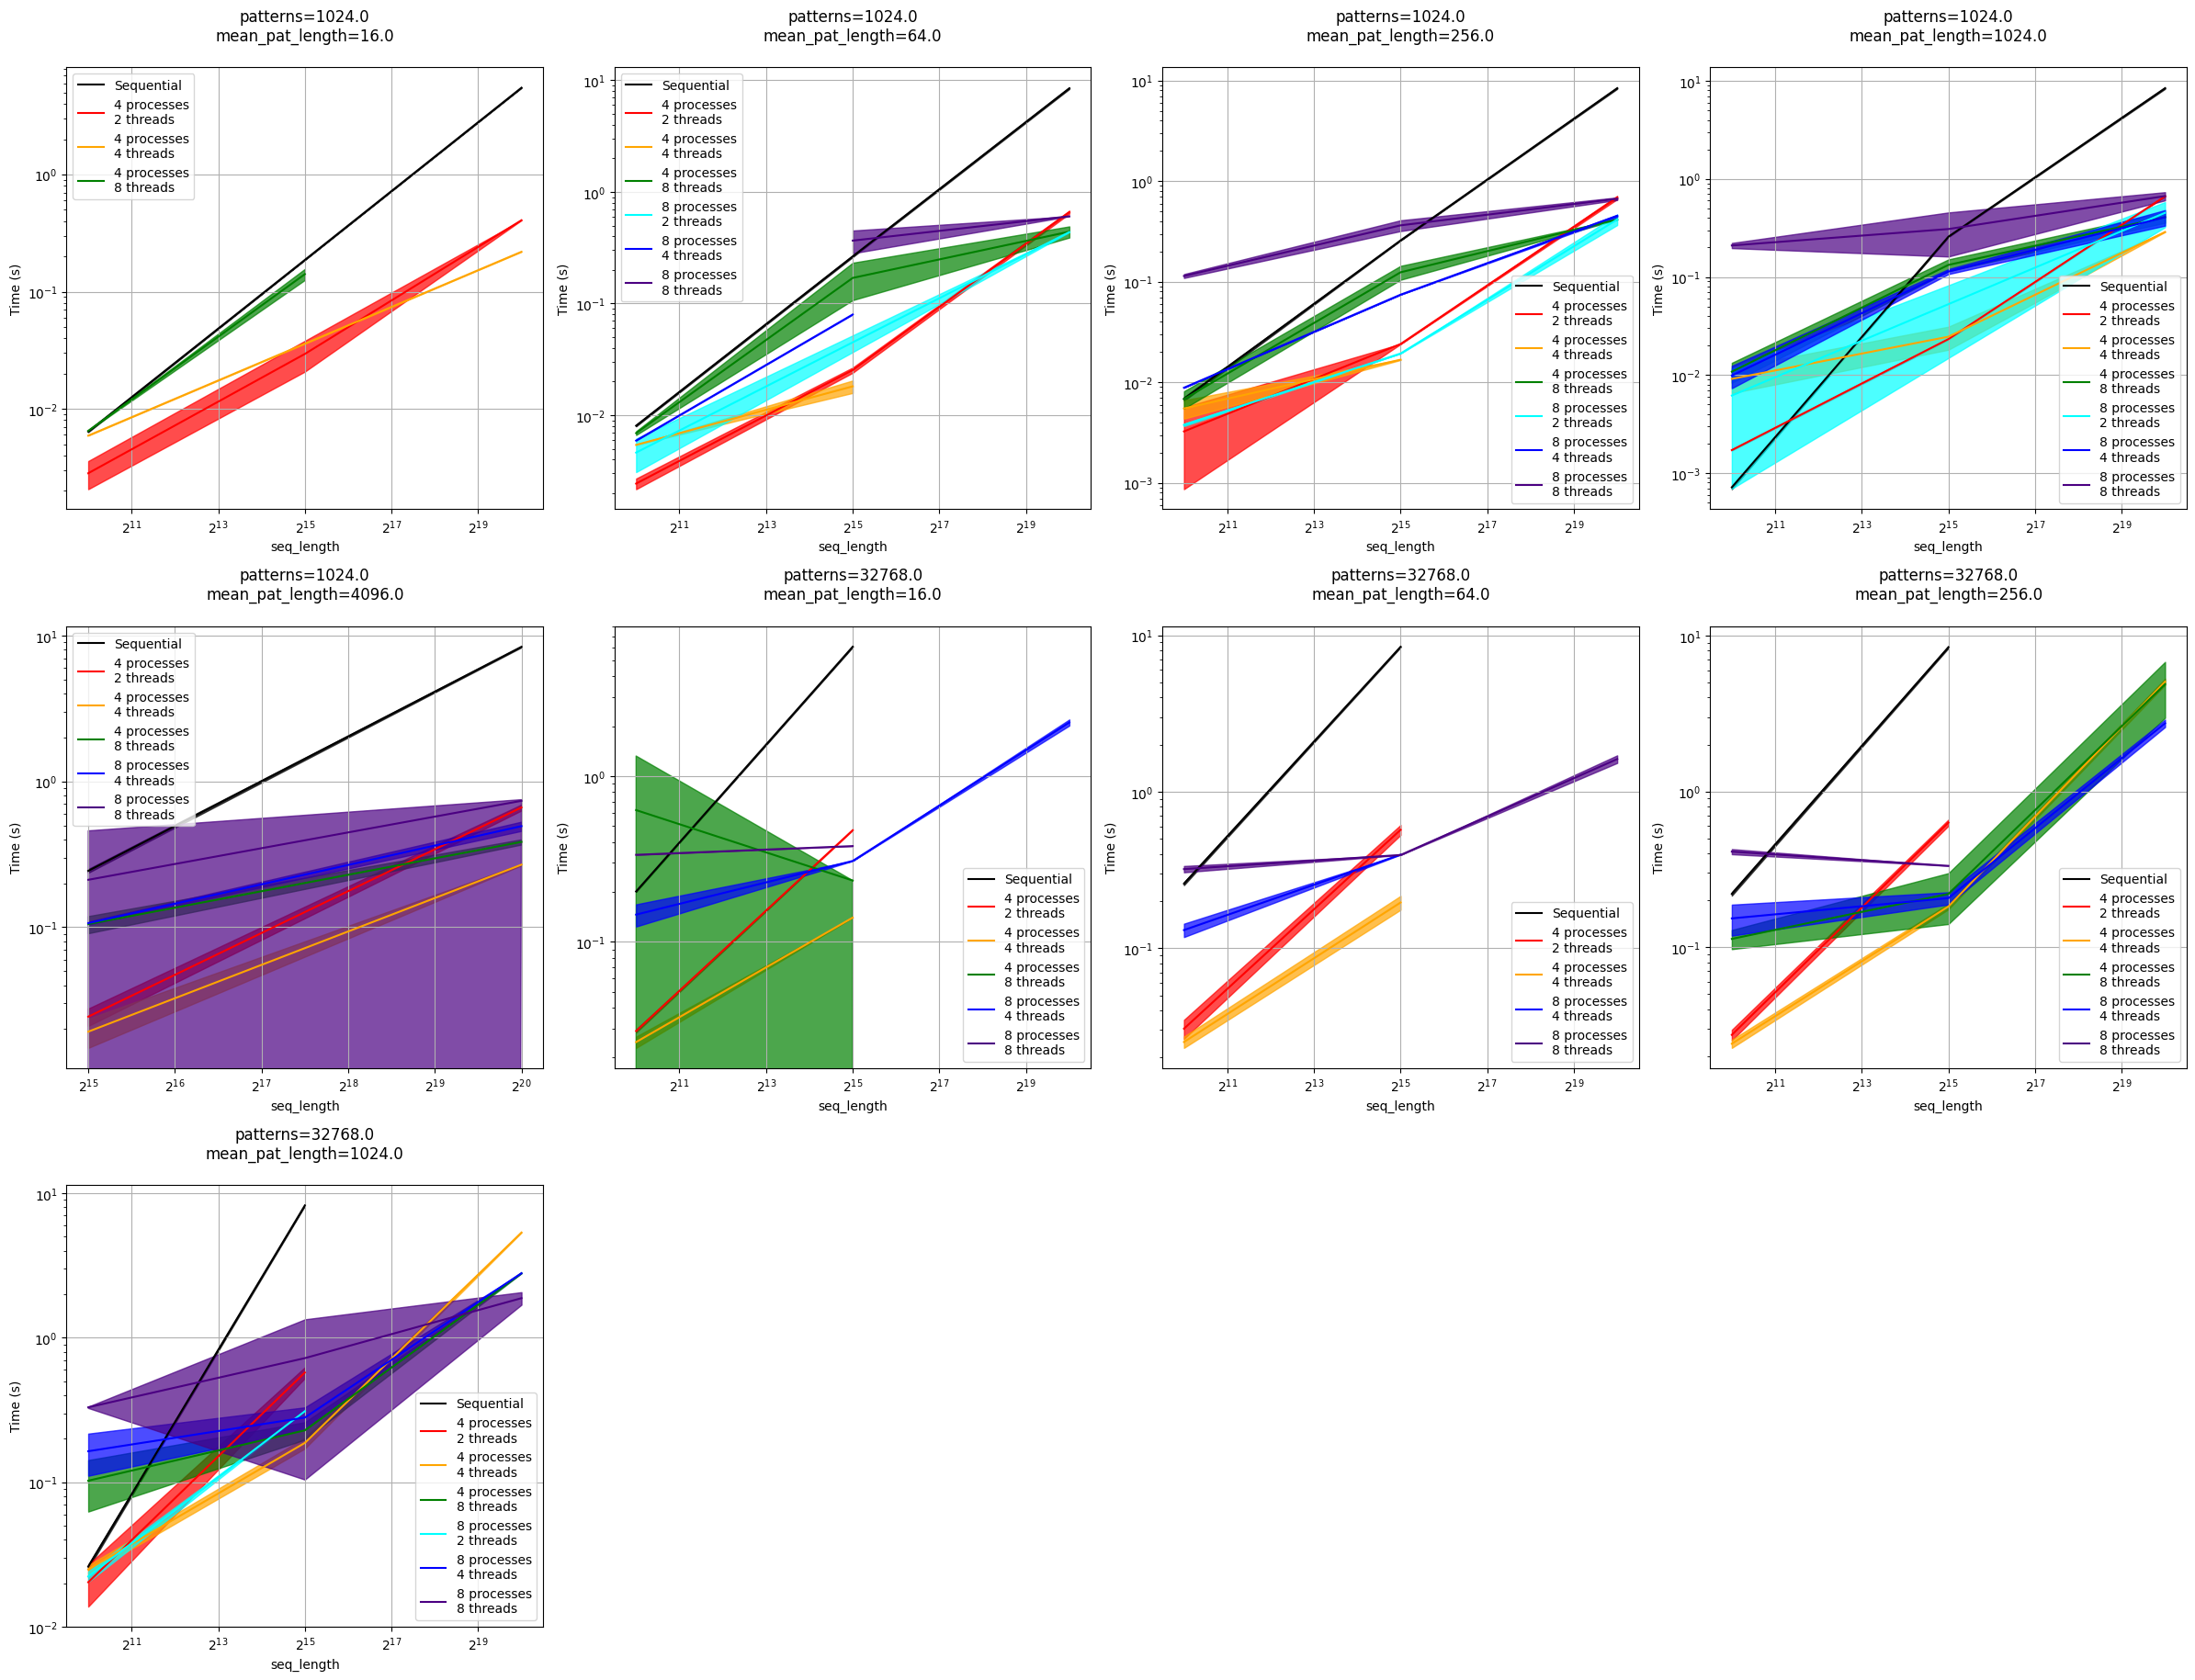

In [125]:
save_plot_variable_sequential_mpipthreads("seq_length")

## Efficiency

In [112]:
%%capture cap
del cap # delete previously existing cap variable

variable = "mean_pat_length"
paradigm = "mpipthreads"
match paradigm:
    case "pthreads":
        final_efficiency(variable, "pthreads")
    case "mpi/simple":
        final_efficiency(variable, "mpi")
    case "mpi/improved":
        final_efficiency(variable, "mpi_exp")
    case "mpi/broadcast":
        final_efficiency(variable, "mpi_bcast")
    case "cuda":
        times_cuda(variable)
    case "mpipthreads":
        times_mpipthreads(variable)      
    case _:
        print("Error in paradigm input")

In [113]:
with open(f"final_folder/results/{paradigm}/efficiency_{variable}.txt", 'w') as f:
    f.write(cap.stdout)